In [1]:
# !pip install -e ../.

from climpyrical.datacube import *
from climpyrical.mask import *
from climpyrical.gridding import *

import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

from sklearn import ensemble
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator
from sklearn.metrics import *
from sklearn.neighbors import KNeighborsRegressor
from scipy import stats
from pykrige.ok import OrdinaryKriging


from sklearn.metrics.pairwise import paired_distances
from scipy.spatial import distance
from scipy.stats import linregress

import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
import chart_studio.plotly as py
from plotly import colors as clr
import chart_studio

chart_studio.tools.set_config_file(world_readable=False,
                             sharing='private')

%load_ext autoreload
%autoreload 2

In [44]:
# PATH_MASK = '../../climpyrical/tests/data/'
PATH = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
PATH_MEAN = '../../climpyrical/tests/data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
# PATH = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ta.nc'
# PATH_MEAN = '../../climpyrical/tests/data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc'
# print(xr.open_dataset(PATH))
# dv = 'heating_degree_days_per_time_period'
dv = 'snw'

dsold = read_data(PATH, dv)
ds_mean = read_data(PATH_MEAN, dv, ['rlon', 'rlat'])
ds_mean.keys()

N = 3
ds = regrid_ensemble(dsold, dv, N)
dsold_max = ds.rlat.values.max()

if 'time' in ds_mean.keys():
    ds_mean = regrid_ensemble(ds_mean.squeeze('time'), dv, N, ['rlon', 'rlat'])
else:
    ds_mean = regrid_ensemble(ds_mean, dv, N, ['rlon', 'rlat'])
mean = ds_mean[dv].values
        
dvmask = 'sftlf'
mask = read_data('../../climpyrical/tests/data/land_mask_CanRCM4_sftlf.nc', dvmask, keys=['rlat', 'rlon'])

if 'time' in mask.keys():
    mask = mask.squeeze('time')
    mask = mask.drop('time')
mask = regrid_ensemble(mask, dvmask, N, ['rlon', 'rlat'])
mask = mask[dvmask].values >= 1.0

assert mean.shape == ds[dv].values[0, ...].shape

In [45]:
mean.shape, dsold_max

((390, 465), 28.3066665048131)

In [46]:
canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)
mean = ds_mean[dv].values

north_ext = 100
newmean = np.ones((mean.shape[0]+north_ext, mean.shape[1]))
newmean_nan = newmean.copy()
newmean_nan[...] = np.nan
newmean_nan[0:mean.shape[0], 0:mean.shape[1]] = mean
newmean[0:mean.shape[0], 0:mean.shape[1]] = mean

# nrlat = np.linspace(ds[dv]rlon.min())
drlat = np.mean(np.diff(ds.rlat))
nrlat = np.linspace(ds.rlat.min(), ds.rlat.max()+north_ext*drlat, mean.shape[0]+north_ext)
nrlon = ds.rlon.copy()

ds_mean = xr.Dataset(
    {dv: (["rlat", "rlon"], newmean), "lon": nrlon, "lat": nrlat},
    coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
)

mean = ds_mean[dv].values.copy()


x, y = flatten_coords(ds_mean.rlon.values, ds_mean.rlat.values)
xy = np.stack([x, y]).T
contained = []

for xcoord, ycoord in xy:
    contained.append(canada.contains(Point(xcoord, ycoord)))

final_mask = np.array(contained).reshape(ds_mean[dv].shape)
contained = np.array(contained).reshape(ds_mean[dv].shape)

In [47]:
final_mask = np.logical_and(final_mask.copy(), ~np.isnan(mean))
assert final_mask.shape == mean.shape

In [48]:
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)
assert rlon.shape == rlat.shape and rlon.shape == final_mask.shape

In [49]:
# df_path = '../../climpyrical/tests/data/Interim_hdd_Tmax_Tmin_delivered.csv'
df_path = '../../climpyrical/tests/data/sl50_short.csv'
df = pd.read_csv(df_path, index_col=None)
# station_dv = 'HDD (degC-day)'
station_dv = 'SL50 (kPa)'

# transform into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

target = '+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'
df.shape

(520, 9)

In [50]:
# nanmean = ~np.isnan(ds_mean[dv].values)
# ds_mean_linear = ds_mean[dv].values.copy()
# f = NearestNDInterpolator(np.stack([rlon[nanmean], rlat[nanmean]]).T, ds_mean[dv].values[nanmean])

# # nrlond = np.linspace(ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlon.size*3)
# # nrlatd = np.linspace(ds_mean.rlat.min(), ds_mean.rlat.max(), ds_mean.rlat.size*3)

# # rlond, rlatd = np.meshgrid(nrlond, nrlatd)

# ds_mean_linear[contained] = f(np.stack([rlon[contained], rlat[contained]]).T)

# ds_mean = xr.Dataset(
#     {dv: (["rlat", "rlon"], ds_mean_linear), "lon": nrlon, "lat": nrlat},
#     coords={"rlon": ("rlon", nrlon), "rlat": ("rlat", nrlat)},
# )

# plt.imshow(ds_mean_linear, origin='lower')

In [51]:
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)
df = df.assign(
        rlon=rlon_st, 
        rlat=rlat_st
)

# find nearest grid cells to station locations in rlon and rlat using haversine distance
nearest_gridcell_idx = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy().flatten(), rlat.copy().flatten()]).T), 
    metric='haversine'
)[0]

nearest_gridcell_idx_masked = pairwise_distances_argmin_min( 
    np.deg2rad(
    np.stack([df.rlon, df.rlat]).T
    ),
    np.deg2rad(np.stack([rlon.copy()[final_mask], rlat.copy()[final_mask]]).T), 
    metric='haversine'
)[0]

# create a mesh of indices of rlon and rlat grids for masking 
irlon, irlat = np.meshgrid(range(ds_mean.rlon.size), range(ds_mean.rlat.size))
# combine indices and extract the nearest grid cell index in x and y axis
ix_non_agg, iy_non_agg = np.stack([irlon.flatten(), irlat.flatten()])[:, nearest_gridcell_idx]
ix_non_agg_masked, iy_non_agg_masked = np.stack([irlon[final_mask], irlat[final_mask]])[:, nearest_gridcell_idx_masked]

# where_nan = np.isnan(mean[iy_non_agg, ix_non_agg])
# ix_non_agg[where_nan] = ix_non_agg_masked[where_nan]
# iy_non_agg[where_nan] = iy_non_agg_masked[where_nan]


# add to dataframe
matched_df = pd.DataFrame({'ilocy': iy_non_agg, 'ilocx': ix_non_agg, 'ilocy_mask': iy_non_agg_masked, 'ilocx_mask': ix_non_agg_masked, station_dv: df[station_dv],'rlat':df.rlat, 'rlon':df.rlon, 'lat': df.lat, 'lon':df.lon, 'station_name':df.station_name})
# aggregate stations in same grid cell by taking mean
matched_df.to_csv('/home/nannau/06172020/dash-dv-explorer/assets/data/snow_stations.csv')
matched_df = matched_df.groupby(['ilocy', 'ilocx'], as_index=False).agg({station_dv: 'mean', 'ilocx_mask': 'mean', 'ilocy_mask': 'mean', 'rlat':'mean', 'rlon':'mean', 'lat': 'mean', 'lon': 'mean', 'station_name': 'first'})#, 'niy': 'min', 'nix': 'min'})


iy = matched_df.ilocy.values
ix = matched_df.ilocx.values
iym, ixm = matched_df.ilocy_mask.values.astype(int), matched_df.ilocx_mask.values.astype(int)

where_nan = np.isnan(ds_mean[dv].values[iy, ix])

station_vals = matched_df[station_dv].values

# comment out for station rlon,rlat
matched_df['rlon'] = rlon[iy, ix]
matched_df['rlat'] = rlat[iy, ix]

matched_df.head()

,ilocy,ilocx,SL50 (kPa),ilocx_mask,ilocy_mask,rlat,rlon,lat,lon,station_name
0,167,303,1.05,303.0,167.0,-4.253331,10.413335,42.304450,-82.94445,WINDSOR RIVERSIDE
1,172,305,1.50,305.0,172.0,-3.519998,10.706668,42.992200,-82.30470,SARNIA AIRPORT
2,173,311,1.50,311.0,173.0,-3.373331,11.586668,43.002000,-81.03280,DORCHESTER
3,173,314,1.60,314.0,173.0,-3.373331,12.026668,42.866700,-80.55000,DELHI CDA
4,173,315,1.60,314.5,173.5,-3.373331,12.173335,42.812195,-80.34788,SIMCOE


In [52]:
def regionalize(array):
    return array[u:lw, l:r].reshape((lw-u, r-l))
def squareize(array):
    ar = mean.copy()
    ar[final_mask] = array
    ar[~final_mask] = np.nan
    return ar
# mean = ds_mean[dv].values
mean[iy[where_nan], ix[where_nan]] = mean[iym[where_nan], ixm[where_nan]]
oldmean = mean.copy()
meanc = mean.copy()
tol = np.linspace(0.1, 10, 10000)

print(np.nanmean(station_vals - meanc[iy, ix]))

if np.nanmean(station_vals - meanc[iy, ix]) >= 0:
    rmtols = np.array([np.mean(matched_df[station_dv] - (meanc[iy, ix]/t)) for t in tol])
    best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0]]

# if np.mean(matched_df[station_dv] - meanc[iy, ix]) < 0:
#     rmtols = np.array([np.mean(matched_df[station_dv] + (meanc[iy, ix]/t)) for t in tol])
#     best_tol = tol[np.where(np.diff(np.sign(rmtols)) != 0.)[0]]

mean = meanc/best_tol
print(best_tol, np.mean(matched_df[station_dv] - mean[iy, ix]))


np.mean(station_vals - mean[iy, ix])
# print(np.mean(matched_df[station_dv] - meanc[iy, ix]))
# print(np.mean(matched_df[station_dv] - mean[iy, ix]))

1.1408527199274456
[0.66138614] -0.0031499064201565338


-0.0031499064201566257

In [53]:
newmean = meanc/best_tol

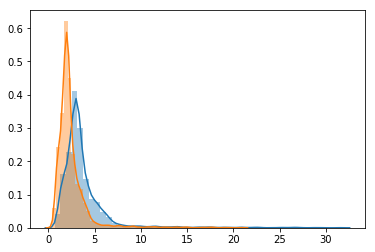

In [54]:
sns.distplot(newmean[final_mask])
sns.distplot(meanc[final_mask])

In [55]:
assert np.sum(~np.isclose(rlon[iy_non_agg, ix_non_agg], df.rlon, atol=0.6)) < 6

In [56]:
# subset of grid cells closest station locations
X = np.stack([rlon[iy, ix], rlat[iy, ix], mean[iy, ix]]).T

# full set of locations we wish to predict a value at
# Xf = np.stack([rlon[final_mask], rlat[final_mask], mean[final_mask]]).T

In [57]:
# from sklearn.gaussian_process.kernels import ConstantKernel

# C_0, rho, length_scale = [0.0762, 1.13, 129/2]

In [58]:
# from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, RBF, RBFMOD
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.model_selection import GridSearchCV

# kernel = ConstantKernel(C_0)+ConstantKernel(rho)*RBFMOD(length_scale)
# krig = GaussianProcessRegressor(alpha=5, random_state=0, kernel=kernel)    

# # clf = GridSearchCV(krig, kernel)
# krig.fit(X, station_vals)

# # sorted(krig.cv_results_.keys())

# krigfield = [krig.predict(Xf)]
# # print(krig.kernel)

# # plt.scatter(station_vals, squareize(krigfield[0])[iy, ix])
# # np.sqrt(mean_squared_error(S[iy, ix], station_vals))

In [59]:
ratio = station_vals/mean[iy, ix] #np.var(station_vals, mean[iy, ix])
matched_df = matched_df.assign(ratio=ratio)
def undo(x, mean):
    return x*mean

def undo_rho(x, mean, rho):
    return ((np.ones(x.shape)-rho)+x)*mean

assert np.any(~np.isnan(ratio))

In [60]:
# !cd "/home/nannau/06172020/climpyrical/"; bash r_install.sh
from rpy2.robjects.packages import importr

importr("fields")#, lib_loc="../../r-library/fields/")
# importr("sp", lib_loc="../../r-library/sp/")
# importr("gstat", lib_loc="../../r-library/gstat/")
# importr("geoR", lib_loc="../../r-library/geoR/")

rpy2.robjects.packages.Package as a <module 'fields'>

In [61]:
dfc = matched_df.copy()

In [62]:
from shapely.geometry import Point, Polygon
import climpyrical.spytialProcess as sp

pairs = {
    'north': {
        'x1': -90,
        'x2': -50,
        'y1': 40,
        'y2': 60
    },
    'east': {
        'x1': -140,
        'x2': -100,
        'y1': 55,
        'y2': 80
    },
    'west': {
        'x1': -140,
        'x2': -90,
        'y1': 48,
        'y2': 60
    }
    
}

Z = mean.copy()
Z_py = mean.copy()
Z_py[...] = np.nan
Z[...] = np.nan

# for key in pairs:
key = 'north'
lon1, lon2 = pairs[key]['x1'], pairs[key]['x2']
lat1, lat2 = pairs[key]['y1'], pairs[key]['y2']

dfc = matched_df.copy()

dfc = dfc.assign(ratio = ratio)

region_cond = ((dfc.lon > lon1) & (dfc.lon < lon2) & (dfc.lat > lat1) & (dfc.lat < lat2))
region_cond_df = ((df.lon > lon1) & (df.lon < lon2) & (df.lat > lat1) & (df.lat < lat2))

dfc = dfc[region_cond]

p1 = (dfc.rlon.min(), dfc.rlat.min())
p2 = (dfc.rlon.max(), dfc.rlat.min())
p3 = (dfc.rlon.max(), dfc.rlat.max())
p4 = (dfc.rlon.min(), dfc.rlat.max())

l, rside = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())
l, r = find_nearest_index(ds.rlon.values, dfc.rlon.min()), find_nearest_index(ds.rlon.values, dfc.rlon.max())

u, lw = find_nearest_index(ds.rlat.values, dfc.rlat.min()), find_nearest_index(ds.rlat.values, dfc.rlat.max())

final_mask_c = final_mask.copy()
region = final_mask.copy() 
region[...] = False
region[u:lw, l:r] = True


# If True, keep station locations in the mask
final_mask_c[iy, ix] = True
# combine region mask and land mask
region = np.logical_and(final_mask_c, region)
region[dfc.ilocy, dfc.ilocx] = True

latlon = np.stack([dfc.rlon, dfc.rlat])
#     stats = dfc['ratio'].values
stats = dfc[station_dv].values

ylim = lw-u
xlim = r-l

#     okie = OrdinaryKriging(dfc.rlon, dfc.rlat, stats, variogram_model='exponential', exact_values=False, coordinates_type = "geographic")
#     krigfield = okie.execute('points', rlon[region], rlat[region])[0]

#     Z_py[region] = krigfield


In [63]:
import matplotlib

from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KDTree

std = StandardScaler() 
N = 10
db = KMeans(n_clusters=N)
# db = DBSCAN(eps=0.2, min_samples=30, metric='haversine')

X = np.stack([matched_df.rlon, matched_df.rlat])
# X
X = std.fit_transform(X.T)
db.fit(X)

db.labels_.shape, matched_df.shape[0]

matched_df = matched_df.assign(label = db.labels_)

# sns.distplot(db.labels_, kde=False)

ccenters = std.inverse_transform(db.cluster_centers_)
xcenter, ycenter = ccenters[:, 0], ccenters[:, 1]

from shapely import geometry

X_distances = np.stack([matched_df.rlon.values, matched_df.rlat.values])
# dfc = matched_df.copy()

Zl = []

In [81]:
latlon = np.stack([dfc.rlon, dfc.rlat]).T
# stats = dfc[station_dv].values
box=5

from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=35, metric='euclidean').fit(X_distances.T)
dist, ind = nbrs.kneighbors(X_distances.T)

# tree = KDTree(X_distances.T, leaf_size=2)
# dist, ind = tree.query(X_distances.T, k=35)

In [82]:
ind.shape
from climpyrical.spytialProcess import *

In [83]:
# from scipy.spatial.distance import cdist
# alpha = 1.0
# d_arr = np.exp(-alpha*cdist(np.stack([matched_df.rlon.values, matched_df.rlat.values]).T, np.stack([rlon.flatten(), rlat.flatten()]).T))
# d_arr = d_arr/np.amax(d_arr, axis=0)
# d_arr = d_arr.reshape((d_arr.shape[0], mean.shape[0], mean.shape[1]))

In [84]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [85]:
# cov.keys()
# np.mean(cov['trA.info'])

In [86]:
# plt.scatter(dfc.rlon.values[ind[120]], dfc.rlat.values[ind[120]])
# dfc = dfc[(dfc.rlon < -5) & (dfc.rlon > -15)& (dfc.rlat > 15) & (dfc.rlat < 25)]

# okie = OrdinaryKriging(matched_df.rlon, matched_df.rlat, matched_df[station_dv], variogram_model='exponential', coordinates_type = "geographic", exact_values=False)
# krigfield_mv_window = okie.execute('points', rlon.flatten(), rlat.flatten(), backend='loop', n_closest_points=35)
# krigfield = okie.execute('points', rlon.flatten(), rlat.flatten(), backend='loop')

# okie.display_variogram_model()
# print(okie.variogram_model_parameters)


plt.imshow(krigfield[0].reshape(mean.shape), origin='lower')
plt.show()
plt.imshow(krigfield_mv_window[0].reshape(mean.shape), origin='lower')

In [87]:
matched_df.iloc[10:20]

,ilocy,ilocx,SL50 (kPa),ilocx_mask,ilocy_mask,rlat,rlon,lat,lon,station_name,ratio,label
10,177,320,0.90,320.0,176.0,-2.786665,12.906669,43.200000,-79.166700,ST CATHARINES A,0.752573,5
11,178,313,2.40,313.0,178.0,-2.639998,11.880002,43.560011,-80.428018,GUELPH OAC composite,1.471484,5
12,179,317,1.40,317.0,179.0,-2.493332,12.466668,43.677200,-79.630600,TORONTO LESTER B. PEARSON INT'L A,1.003878,5
13,179,318,1.45,317.5,179.5,-2.493332,12.613335,43.610535,-79.440027,TORONTO ISLAND A,1.039731,5
14,180,311,2.10,311.0,180.0,-2.346665,11.586668,43.983300,-80.750000,MOUNT FOREST,1.072699,5
15,180,316,1.50,316.0,180.0,-2.346665,12.320002,43.808100,-79.808100,SANDHILL,0.943441,5
16,180,318,1.45,318.0,180.0,-2.346665,12.613335,43.723350,-79.433900,TORONTO,1.144637,5
17,181,318,1.70,318.0,181.0,-2.199998,12.613335,43.869700,-79.408900,RICHMOND HILL,1.341988,5
18,182,311,2.90,311.0,182.0,-2.053332,11.586668,44.203600,-80.637800,PRICEVILLE,1.481347,5
19,182,315,1.80,315.0,182.0,-2.053332,12.173335,44.151400,-79.872200,ALLISTON NELSON,1.132130,5


In [88]:
from tqdm import tqdm
import scipy as np
import scipy.ndimage as ndi
mean_laplace = np.nanmean(np.absolute(ndi.filters.laplace(ds_mean[dv].values)))

In [89]:
# show station locations
# separate the station only reconstruction and create reconstructions in groups of 5 side by side
# create ratio reconstruction with 50-75% coverage with nmin=35

In [90]:
i_to_drop = []
i_of_drop = []
Zl = []
Zl_r = []
# dfc = matched_df.copy()
# matched_df_region = dfc.copy()
# dfc = matched_df_region.copy()
dfc = matched_df.copy()

from sklearn.neighbors import NearestNeighbors
# nbrs = NearestNeighbors(n_neighbors=35, metric='euclidean').fit(X_distances.T)
# dist, ind = nbrs.kneighbors(X_distances.T)

loglike = []
reml = []
rmse = []
function_name = []

xc, yc = -10, 17.5
# i = 454
i = 0 
# i = 40
print("LON, LAT", df.lon[i], df.lat[i])

per_station_loglike = []

nneighs = np.arange(35, dfc.shape[0])

nug_arr = []
pykrige_variogram_parameters = []

# Three conditions to meet:

# 1.) At least 35 stations in a window [x]
# 2.) Minimum area must be 5x5 grid [x]
# 3.) Windows can not have greater than 50% coverage of any other window [x]

area = np.zeros(mean.shape)
X_distances = np.stack([dfc.rlon.values, dfc.rlat.values])
N = dfc.values.shape[0]

from scipy.spatial import ConvexHull

dA = (np.amax(ds_mean.rlon.values)-np.amin(ds_mean.rlon.values))/ds_mean.rlon.size

Zl = np.empty((N, ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]))
Zl[...] = np.nan

contained = np.array(contained).reshape(mean.shape) 

from tqdm import tqdm
import warnings

m, o = 6, 6
nn_val = 40
warnings.simplefilter("ignore")
horizon = 5

dfc = matched_df.copy()

LON, LAT -123.742 48.935


In [91]:
df_north = dfc[dfc.rlat > dsold_max].copy()
df_south = dfc[dfc.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

In [92]:
south_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [93]:
spacing = np.arange(10, 31, 5)
extent=[ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()]

In [94]:
dfc.rlat.idxmax(axis=0, skipna=True)
dfc = matched_df.copy()

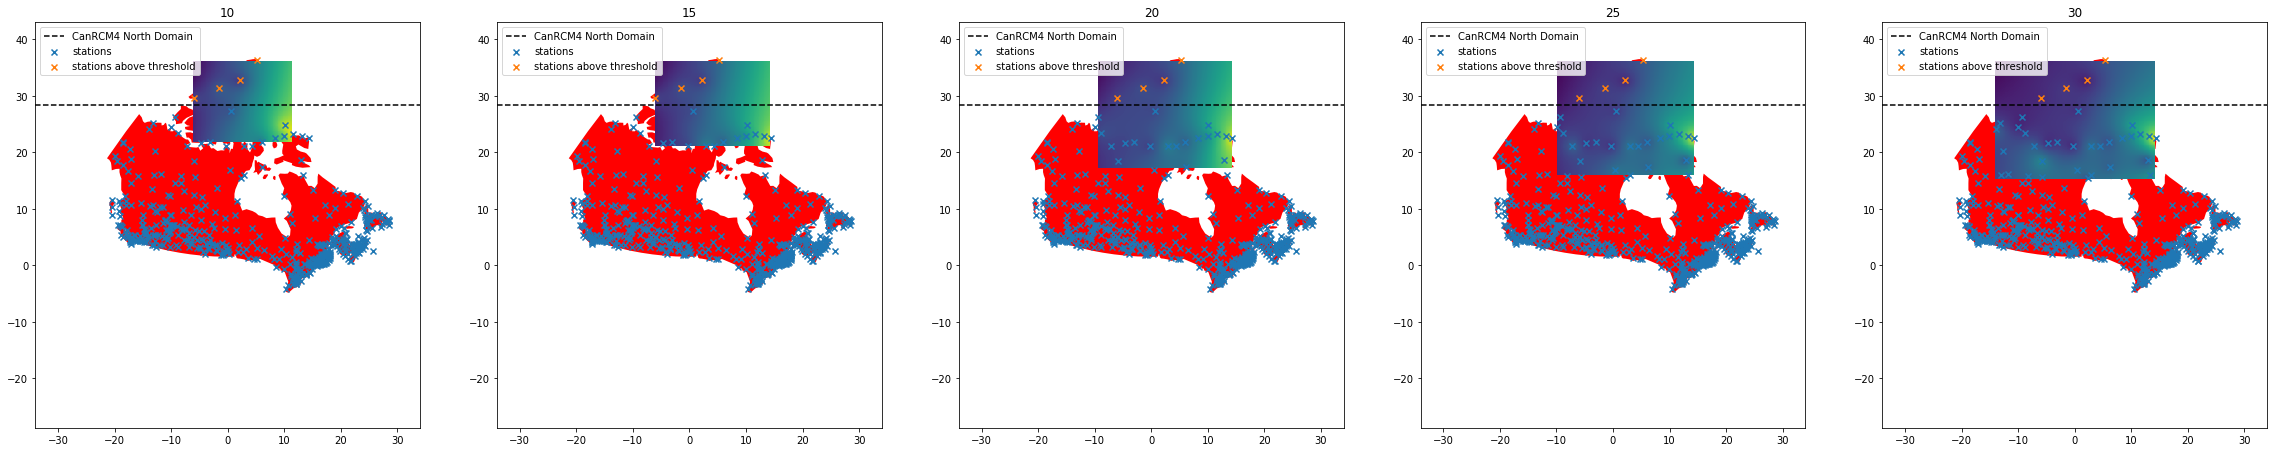

In [107]:
Zl = np.empty((N, ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]))
Zl[...] = np.nan
station_only_final = []
X_distances = np.stack([dfc.rlon.values, dfc.rlat.values])


fig, ax = plt.subplots(1, 5, figsize=(40, 20))

imax = dfc.rlat.idxmax(axis=0, skipna=True)

for ixm, nn_val in enumerate(spacing):

    nbrs = NearestNeighbors(n_neighbors=nn_val, metric='euclidean').fit(X_distances.T)
    dist, ind = nbrs.kneighbors(X_distances.T)
    temp_df = dfc.iloc[ind[imax]]

    xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
    ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df[station_dv]

    lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
    l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
    ylim = u-lw
    xlim = r-l    

#     try:
    z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=True)

    final = ds_mean[dv].values.copy()
    final[:, :] = np.nan
    final[lw:u, l:r] = z.T

    nanmask = ~np.isnan(final)

#     Zl[index, ...] = final
#     except:
#         continue
#     station_only_final.append(np.nanmean(Zl, axis=0))
    station_only_final.append(final)

    ax[ixm].imshow(final, origin='lower', extent=extent)
    ax[ixm].set_title(f'{spacing[ixm]}')
    ax[ixm].axhline(dsold_max, color='black', ls='--', label='CanRCM4 North Domain')
    ax[ixm].scatter(dfc.rlon.values[south_index], dfc.rlat.values[south_index], label='stations', marker='x')
    ax[ixm].scatter(dfc.rlon.values[north_index], dfc.rlat.values[north_index], label='stations above threshold', marker='x')
    canada.plot(ax=ax[ixm], color='red', zorder=0)
    ax[ixm].legend()
plt.savefig('station-only-north-mean-extrap')    
plt.show()


In [96]:
nbrs = NearestNeighbors(n_neighbors=20, metric='euclidean').fit(X_distances.T)
dist, ind = nbrs.kneighbors(X_distances.T)
temp_df = dfc.iloc[ind[imax]]

xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

latlon = np.stack([temp_df.rlon, temp_df.rlat])
stats = temp_df[station_dv]

lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
ylim = u-lw
xlim = r-l    

#     try:
z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=True)

final = ds_mean[dv].values.copy()
final[:, :] = np.nan
final[lw:u, l:r] = z.T

station_final_north = final.copy()

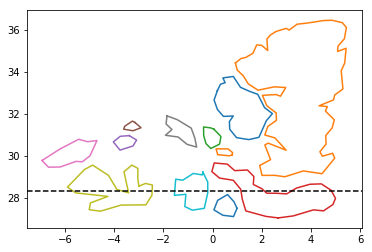

In [97]:
# for polygon in canada.geometry:
#     print(polygon.area)
    
gdf = gpd.GeoDataFrame(canada)
canada_polygons = np.array(gdf.geometry[0])
polygon_above_north_idx = np.array([p.centroid.y + 1 >= dsold_max for p in canada_polygons]) 

for p in canada_polygons[polygon_above_north_idx]:
    x,y = p.exterior.xy
    plt.plot(x,y)

plt.gca().axhline(dsold_max, ls='--', color='black')
plt.show()

rlat_above_thresh = ds_mean.rlat >= dsold_max - 1.

xx, yy = flatten_coords(ds_mean.rlon, ds_mean.rlat.values[rlat_above_thresh])
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

# gen_raster_mask_from_vector(ds_mean.rlon.values, ds_mean.rlat.values[rlat_above_thresh], gpd.GeoSeries(canada_polygons[polygon_above_north_idx]))
# grid = np.meshgrid(x, y)[0]
# for i, rlon in enumerate(ds_mean.rlon):
#     for j, rlat in enumerate(ds_mean.rlat.values[rlat_above_thresh]):
#         pt = Point(rlon, rlat)
#         grid[j, i] = p.contains(pt)
        
from shapely.geometry.multipolygon import MultiPolygon

northern_mask = gen_raster_mask_from_vector(ds_mean.rlon.values, ds_mean.rlat.values, gpd.GeoSeries(MultiPolygon(list(canada_polygons[polygon_above_north_idx]))))

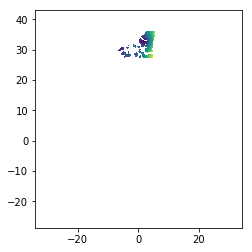

In [98]:
station_final_north[~northern_mask] = np.nan
plt.imshow(station_final_north, origin='lower', extent=[ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()])

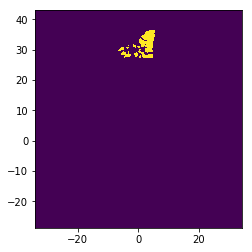

In [99]:
plt.imshow(np.logical_and(northern_mask, contained), origin='lower', extent=[ds_mean.rlon.min(), ds_mean.rlon.max(), ds_mean.rlat.min(), ds_mean.rlat.max()])

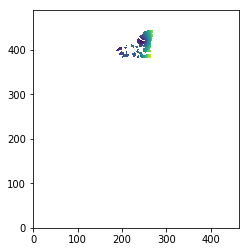

In [100]:
st_nan = ~np.isnan(station_final_north)
f = NearestNDInterpolator(np.stack([rlon[st_nan], rlat[st_nan]]).T, station_final_north[st_nan])
station_final_north[np.logical_and(northern_mask, contained)] = f(np.stack([rlon[np.logical_and(northern_mask, contained)], rlat[np.logical_and(northern_mask, contained)]]).T)

plt.imshow(station_final_north, origin='lower')

In [101]:
mean_laplace = np.nanmean(np.absolute(ndi.filters.laplace(ds_mean[dv].values)))
station_only_laplace = np.array([np.nanmean(np.absolute(ndi.filters.laplace(st))) for st in station_only_final])#/mean_laplace
station_only_laplace

array([0.00118111, 0.00161952, 0.00153221, 0.00198169, 0.00207729])

In [102]:
tag = []
frac_cov = 1.0
Zl = np.empty((N, ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]))
Zl[...] = np.nan

X_distances = np.stack([dfc.rlon.values[south_index], dfc.rlat.values[south_index]])

for i in tqdm(south_index):
    nn = 40

    nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
    dist, ind = nbrs.kneighbors(X_distances.T)
    temp_df = dfc.iloc[ind[i]]

    xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
    ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

    latlon = np.stack([temp_df.rlon, temp_df.rlat])
    stats = temp_df.ratio

    lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
    l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
    ylim = u-lw
    xlim = r-l

    hull = ConvexHull(points=latlon.T)
    stats = temp_df.ratio

    while hull.area < (dA**2)*(3*5)**2:
        nn+=1
        nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
        dist, ind = nbrs.kneighbors(X_distances.T)

        temp_df = dfc.iloc[ind[i]]

        xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
        ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

        latlon = np.stack([temp_df.rlon, temp_df.rlat])

        hull = ConvexHull(points=latlon.T)
        stats = temp_df.ratio

        lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
        l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
        ylim = u-lw
        xlim = r-l

    try:
        z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=False)

        final = ds_mean[dv].values.copy()
        final[:, :] = np.nan
        final[lw:u, l:r] = z.T

        nanmask = ~np.isnan(final)
        area[nanmask] += 1.0

        # field already has kriged values in it? If so, where, True?
        n_tot = np.sum(nanmask)
        n_sum = np.sum(
                      area[nanmask] > 1.0
                )

        if float(n_sum)/n_tot >= frac_cov:
            area[lw:u, l:r] -= 1.0
        else:
            Zl[i, ...] = final

    except:
        continue


 12%|█▏        | 59/490 [00:23<02:19,  3.08it/s]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages

R[write to console]: 3: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R

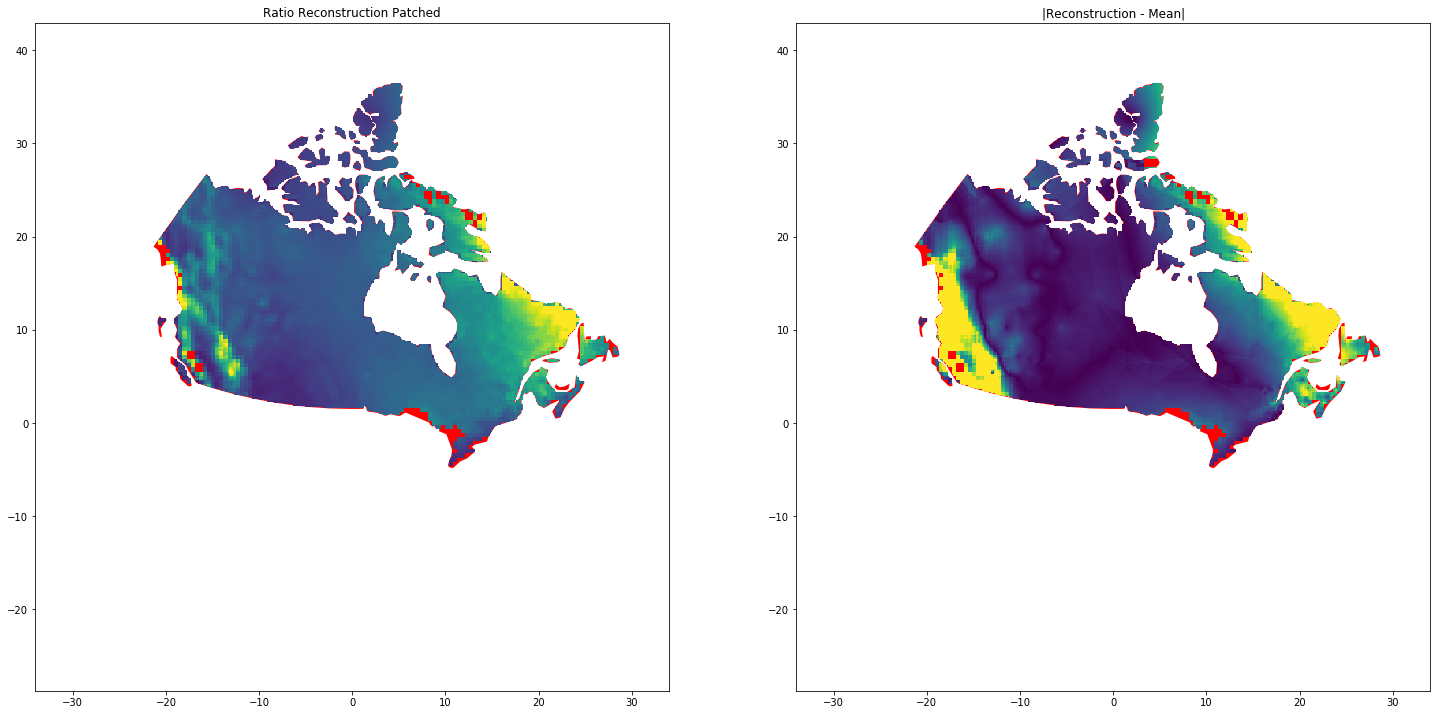

In [103]:
ratio = np.nanmean(Zl, axis = 0)

r_nan = ~np.isnan(ratio)
f = NearestNDInterpolator(np.stack([rlon[r_nan], rlat[r_nan]]).T, ratio[r_nan])
ratio[contained^northern_mask] = f(np.stack([rlon[contained^northern_mask], rlat[contained^northern_mask]]).T)

ratio_final = ratio*ds_mean[dv].values
# final_final = np.nansum(station_only_final, ratio_final)
ratio_final[northern_mask] = np.array(station_final_north)[northern_mask]
ratio_final[~contained] = np.nan
fig, ax = plt.subplots(1, 2, figsize=(25, 25))
ax[0].imshow(ratio_final, origin='lower', vmin=0, vmax=7, extent=extent)
ax[0].set_title('Ratio Reconstruction Patched')
canada.plot(ax=ax[0], zorder=0, color='red')

ax[1].imshow(np.absolute(ratio_final-ds_mean[dv].values), origin='lower', vmin=0, vmax=2, extent=extent)
ax[1].set_title('|Reconstruction - Mean|')
canada.plot(ax=ax[1], zorder=0, color='red')
plt.savefig('non-interp-full-reconstruction-patched')

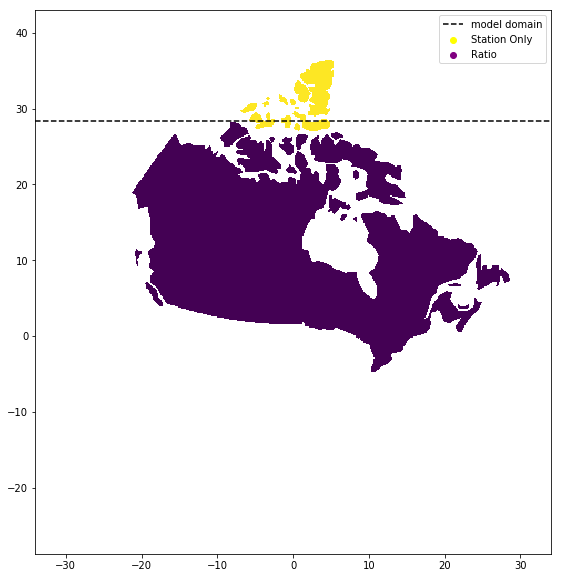

In [105]:
zro = np.zeros(ds_mean[dv].shape)
zro[:] = np.nan
zro[northern_mask] = 1.0
zro[contained^northern_mask] = 0.

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(zro, origin='lower', extent=extent)
plt.scatter(0., 10., label='Station Only', color='yellow', zorder=0)
plt.scatter(0., 10., label='Ratio', color='purple', zorder=0)
plt.gca().axhline(dsold_max, ls='--', color='black', label='model domain')
plt.legend()
plt.savefig('regimes')


In [256]:
# tag = []
# frac_cov = 0.7
# Zl_stations = np.empty((N, ds_mean[dv].values.shape[0], ds_mean[dv].values.shape[1]))
# Zl_stations[...] = np.nan

# X_distances = np.stack([dfc.rlon.values, dfc.rlat.values])

# for i in dfc.index:
#     nn = 40

#     nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
#     dist, ind = nbrs.kneighbors(X_distances.T)
#     temp_df = dfc.iloc[ind[i]]

#     xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
#     ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

#     latlon = np.stack([temp_df.rlon, temp_df.rlat])

#     lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
#     l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
#     ylim = u-lw
#     xlim = r-l

#     hull = ConvexHull(points=latlon.T)
#     stats = temp_df[station_dv].values
# #     stats = temp_df.ratio#[station_dv]
 
#     while hull.area < (dA**2)*(3*5)**2:
#         nn+=1
#         nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
#         dist, ind = nbrs.kneighbors(X_distances.T)

#         temp_df = dfc.iloc[ind[i]]

#         xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
#         ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

#         latlon = np.stack([temp_df.rlon, temp_df.rlat])

#         hull = ConvexHull(points=latlon.T)
#         stats = temp_df[station_dv].values
# #         stats = temp_df.ratio

#         lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
#         l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
#         ylim = u-lw
#         xlim = r-l

#     try:
#         z, x, y, cov = sp.fit(latlon, stats, xlim, ylim, extrap=False)

#         final = ds_mean[dv].values.copy()
#         final[:, :] = np.nan
#         final[lw:u, l:r] = z.T

#         nanmask = ~np.isnan(final)
#         area[nanmask] += 1.0

#         # field already has kriged values in it? If so, where, True?
#         n_tot = np.sum(nanmask)
#         n_sum = np.sum(
#                       area[nanmask] > 1.0
#                 )

#         if float(n_sum)/n_tot >= frac_cov:
#             area[lw:u, l:r] -= 1.0
#         else:
#             Zl_stations[i, ...] = final

#     except:
#         continue

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.293 0 0.292

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.481 0 0.482

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.06 0 0.059

From cffi callback <function _processevents at 0x7f4fa1eb6bf8>:
Traceback (most recent call last):
  File "/home/nannau/tri/lib/python3.6/site-packages/rpy2/rinterface_lib/callbacks.py", line 265, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt
From cffi callback <function _processevents at 0x7f4fa1eb6bf8>:
Traceback (most recent call last):
  File "/home/nannau/tri/lib/python3.6/site-packages/rpy2/rinterface_lib/callb

In [257]:
# rec_stations_final = np.nanmean(Zl_stations, axis=0)
# zlcopy[ds[dv].values.shape[1]:ds[dv].values.shape[1]+north_ext, :] = np.nan
# plt.imshow(zlcopy, origin='lower')


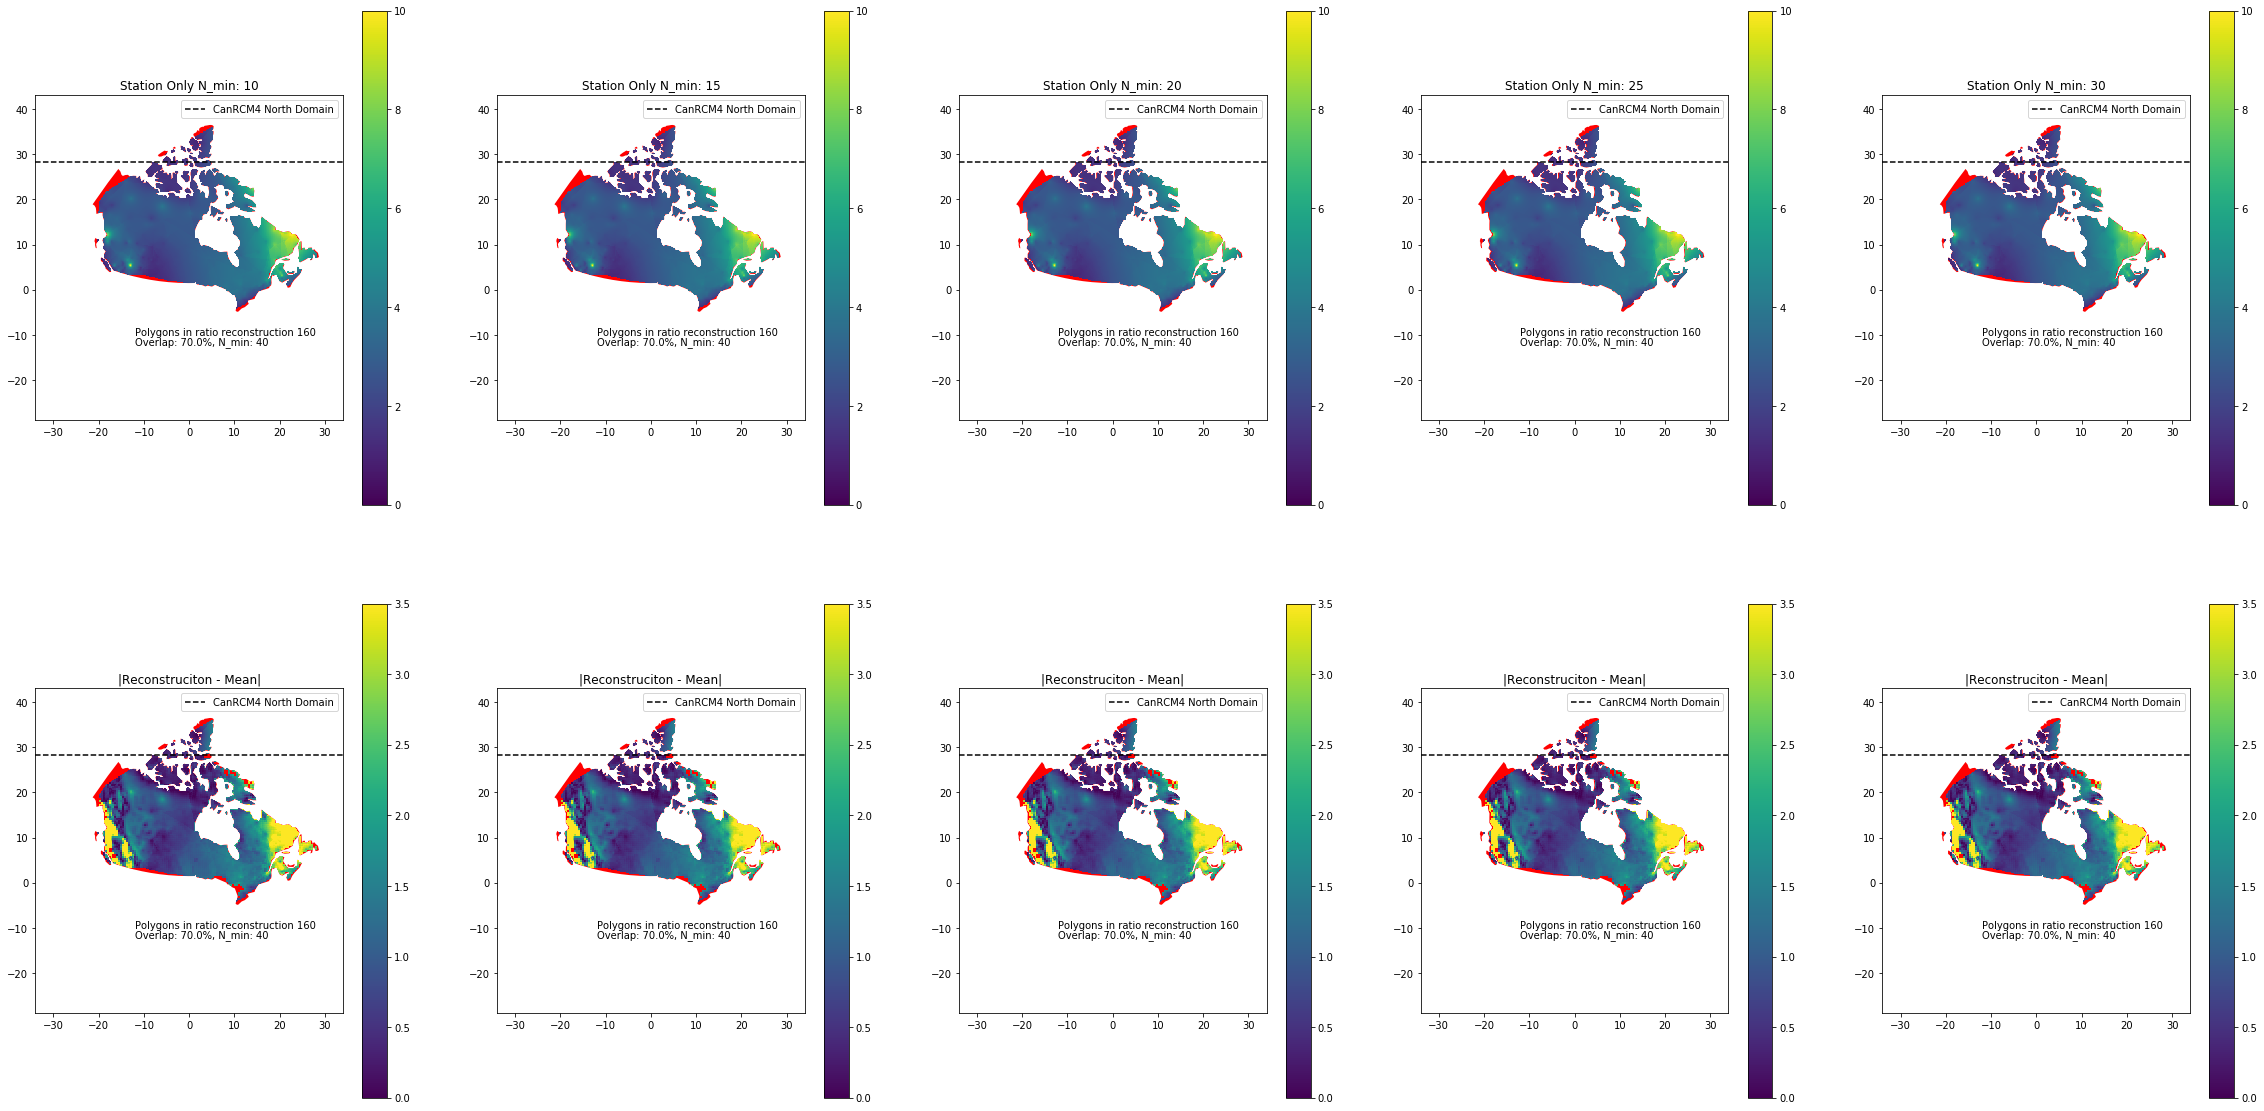

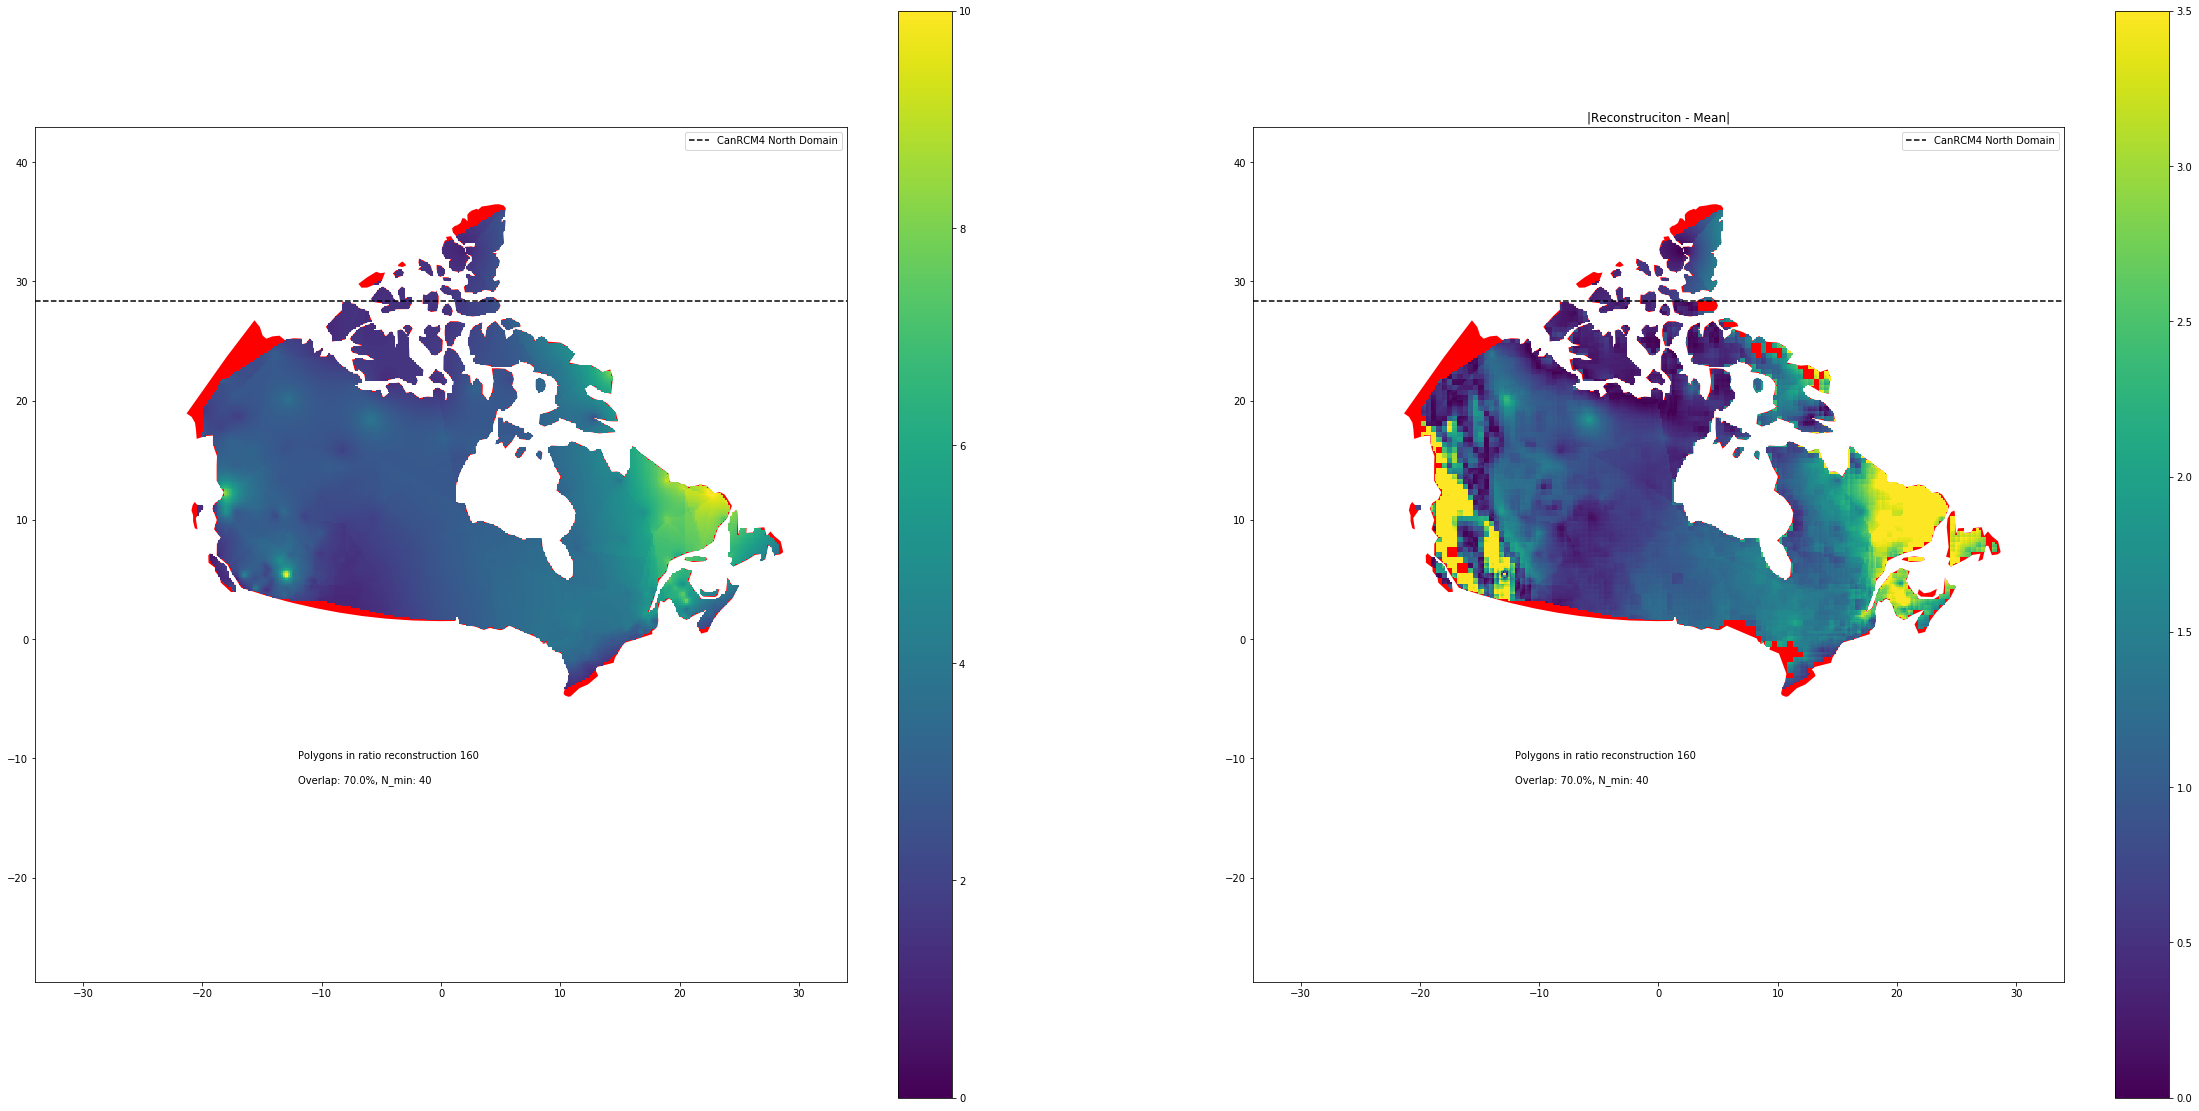

In [154]:
from matplotlib import rc
rc("text", usetex=False)
fig, ax = plt.subplots(2, len(station_only_final), figsize=(40, 20))
for i, station_final in enumerate(station_only_final):
    rec_final = np.nanmean(Zl, axis=0)#*ds_mean[dv].values#np.nanmean(np.stack([np.nanmean(Zl, axis=0)*ds_mean[dv].values, station_final]), axis=0)
#     rec_final[ds[dv].values.shape[1]:ds[dv].values.shape[1]+north_ext, :] = np.nan
    rec_final[~contained] = np.nan
    col = ax[0, i].imshow(rec_final, origin='lower', vmin=0, vmax=10, extent=extent)
    ax[0, i].set_title(f'Station Only N_min: {spacing[i]}')
    ax[0, i].text(-12, -10, 'Polygons in ratio reconstruction {}'.format(Zl.shape[0]-np.sum(zl_isnan)))
    ax[0, i].text(-12, -12, f'Overlap: {100*frac_cov}%, N_min: 40')
#     ax[i].text(-20, -14, f'Relative Laplacian of Residual Field [L[reconstruction-mean]] {np.nanmean(np.absolute(ndi.filters.laplace(rec_final-ds_mean[dv].values)))}')
    ax[0, i].axhline(dsold_max, color='black', ls='--', label='CanRCM4 North Domain')
#     ax[0, i].scatter(dfc.rlon.values[south_index], dfc.rlat.values[south_index], label='stations', marker='x')
#     ax[0, i].scatter(dfc.rlon.values[north_index], dfc.rlat.values[north_index], label='stations above threshold', marker='x')
    canada.plot(ax=ax[0, i], zorder=0, color='red')
    plt.colorbar(col, ax=ax[0, i])
    ax[0, i].legend()
    
    col = ax[1, i].imshow(np.absolute(rec_final-ds_mean[dv].values), vmin=0, vmax=3.5, origin='lower', extent=extent)
    ax[1, i].set_title(f'|Reconstruciton - Mean|')
    ax[1, i].text(-12, -10, 'Polygons in ratio reconstruction {}'.format(Zl.shape[0]-np.sum(zl_isnan)))
    ax[1, i].text(-12, -12, f'Overlap: {100*frac_cov}%, N_min: 40')
    ax[1, i].axhline(dsold_max, color='black', ls='--', label='CanRCM4 North Domain')
#     ax[1, i].scatter(dfc.rlon.values[south_index], dfc.rlat.values[south_index], label='stations', marker='x')
#     ax[1, i].scatter(dfc.rlon.values[north_index], dfc.rlat.values[north_index], label='stations above threshold', marker='x')
    canada.plot(ax=ax[1, i], zorder=0, color='red')
    plt.colorbar(col, ax=ax[1, i])
    ax[1, i].legend()
plt.savefig('station_only_70_cov_residual')    
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(40, 20))
rec_final = np.nanmean(Zl, axis=0)#*ds_mean[dv].values#np.nanmean(np.stack([np.nanmean(Zl, axis=0)*ds_mean[dv].values, station_final]), axis=0)
# rec_final[ds[dv].values.shape[1]:ds[dv].values.shape[1]+north_ext, :] = np.nan
rec_final[~contained] = np.nan
col = ax[0].imshow(rec_final, origin='lower', vmin=0, vmax=10, extent=extent)
# ax[0].set_title(f'Station Only N_min: {spacing[i]}')
ax[0].text(-12, -10, 'Polygons in ratio reconstruction {}'.format(Zl.shape[0]-np.sum(zl_isnan)))
ax[0].text(-12, -12, f'Overlap: {100*frac_cov}%, N_min: 40')
#     ax[i].text(-20, -14, f'Relative Laplacian of Residual Field [L[reconstruction-mean]] {np.nanmean(np.absolute(ndi.filters.laplace(rec_final-ds_mean[dv].values)))}')
ax[0].axhline(dsold_max, color='black', ls='--', label='CanRCM4 North Domain')
#     ax[0, i].scatter(dfc.rlon.values[south_index], dfc.rlat.values[south_index], label='stations', marker='x')
#     ax[0, i].scatter(dfc.rlon.values[north_index], dfc.rlat.values[north_index], label='stations above threshold', marker='x')
canada.plot(ax=ax[0], zorder=0, color='red')
plt.colorbar(col, ax=ax[0])
ax[0].legend()

col = ax[1].imshow(np.absolute(rec_final-ds_mean[dv].values), vmin=0, vmax=3.5, origin='lower', extent=extent)
ax[1].set_title(f'|Reconstruciton - Mean|')
ax[1].text(-12, -10, 'Polygons in ratio reconstruction {}'.format(Zl.shape[0]-np.sum(zl_isnan)))
ax[1].text(-12, -12, f'Overlap: {100*frac_cov}%, N_min: 40')
ax[1].axhline(dsold_max, color='black', ls='--', label='CanRCM4 North Domain')
#     ax[1, i].scatter(dfc.rlon.values[south_index], dfc.rlat.values[south_index], label='stations', marker='x')
#     ax[1, i].scatter(dfc.rlon.values[north_index], dfc.rlat.values[north_index], label='stations above threshold', marker='x')
canada.plot(ax=ax[1], zorder=0, color='red')
plt.colorbar(col, ax=ax[1])
ax[1].legend()
plt.savefig("70_p_coverage_station_only")
plt.show()

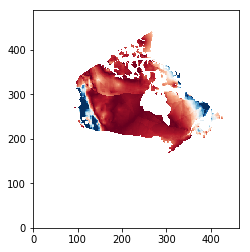

In [186]:
plt.imshow(np.absolute(rec_final-ds_mean[dv].values), origin='lower', vmin=0, vmax=3, cmap='RdBu')

In [ ]:
for xii, frac_cov in tqdm(enumerate(np.linspace(.5, 1, m))):
    for yjj, nn_val in enumerate(np.arange(20, 50, o-1)):
        for i in np.arange(N):
            warnings.simplefilter("ignore")

            nn = nn_val

            nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
            dist, ind = nbrs.kneighbors(X_distances.T)
            temp_df = dfc.iloc[ind[i]]

            xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
            ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

            latlon = np.stack([temp_df.rlon, temp_df.rlat])
            stats = temp_df[station_dv]
            stats_rat = temp_df.ratio

            lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
            l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
            ylim = u-lw
            xlim = r-l

            hull = ConvexHull(points=latlon.T)

            #Get centoid
            cy = np.mean(hull.points[hull.vertices,1])
            ncondition = cy > dsold_max - horizon
            
            if ncondition:
                stats = temp_df[station_dv]
            else:
                stats = temp_df.ratio

            while hull.area < (dA**2)*(3*5)**2:
                nn+=1
                nbrs = NearestNeighbors(n_neighbors=nn, metric='euclidean').fit(X_distances.T)
                dist, ind = nbrs.kneighbors(X_distances.T)

                temp_df = dfc.iloc[ind[i]]

                xmin, xmax = temp_df.rlon.min(), temp_df.rlon.max()
                ymin, ymax = temp_df.rlat.min(), temp_df.rlat.max()

                latlon = np.stack([temp_df.rlon, temp_df.rlat])

                hull = ConvexHull(points=latlon.T)

                cy = np.mean(hull.points[hull.vertices,1])
                ncondition = cy > dsold_max - horizon

                if ncondition:
                    stats = temp_df[station_dv]
                else:
                    stats = temp_df.ratio

                lw, u = find_nearest_index(ds_mean.rlat.values, ymin), find_nearest_index(ds_mean.rlat.values, ymax)
                l, r = find_nearest_index(ds_mean.rlon.values, xmin), find_nearest_index(ds_mean.rlon.values, xmax)
                ylim = u-lw
                xlim = r-l

            try:
                z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)

                final = ds_mean[dv].values.copy()
                final[:, :] = np.nan
                final[lw:u, l:r] = z.T

                nanmask = ~np.isnan(final)
                area[nanmask] += 1.0

                # field already has kriged values in it? If so, where, True?
                n_tot = np.sum(nanmask)
                n_sum = np.sum(
                              area[nanmask] > 1.0
                        )

                if not ncondition:
                    if float(n_sum)/n_tot >= frac_cov:
                        area[lw:u, l:r] -= 1.0
                    else:
                        Zl[i, ...] = final
                else:
                    Zl[i, ...] = final

            except:
                continue

        rec_ratio = np.nanmean(Zl, axis=0)
        rec_nan = np.isnan(rec_ratio)
        trouble_areas = np.logical_and(rec_nan, contained)

        f = NearestNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, rec_ratio[~rec_nan])
        rec_ratio[trouble_areas] = f(np.stack([rlon[trouble_areas], rlat[trouble_areas]]).T)

        rec_final = rec_ratio*ds_mean[dv].values
        rec_final[~contained] = np.nan

        # plt.imshow(rec_final, origin='lower')

        col2 = ax[xii, yjj].imshow(rec_final, origin='lower', vmin=0, vmax=8)
        ax[xii, yjj].set_title(f'Hybrid Reconstruction Masked. {frac_cov} Overlap, {nn} NN')
        plt.colorbar(col2, ax=ax[xii, yjj])

plt.savefig('master')

LON, LAT -123.742 48.935


0it [00:00, ?it/s]R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.011 0 0.011

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.02 0.004 0.023

R[write to console]: Error in (function (par, fn, gr = NULL, ..., method = c("Nelder-Mead",  : 
  non-finite value supplied by optim

R[write to console]: Timing stopped at: 0.066 0 0.065

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.012 0 0.013

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.013 0.004 0.016

R[write to console]: Error in (function (par, fn, gr = NULL, ..., meth

CENTROID: 24.951666716765363
CENTROID: 23.485000142755425
CENTROID: 25.457142875308072
CENTROID: 25.959999986397197
CENTROID: 25.268571458649653


R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.013 0 0.013

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0

R[write to console]: Timing stopped at: 0.013 0 0.013



KeyboardInterrupt: 

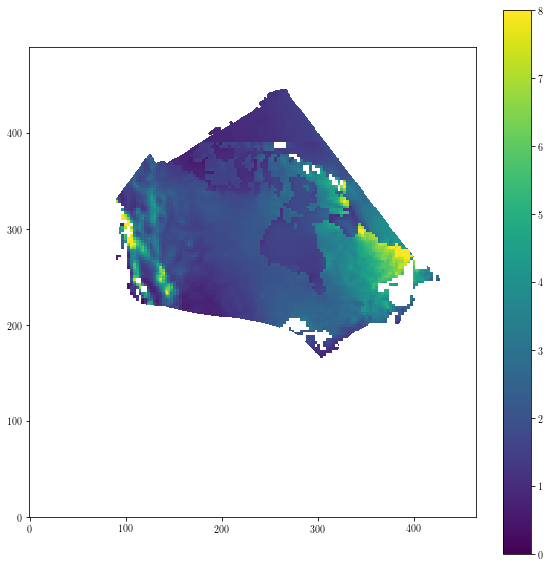

In [42]:
plt.figure(figsize=(10,10))
col = plt.imshow(rec_ratio*ds_mean[dv].values, origin='lower', vmin=0, vmax=8)
plt.colorbar(col)

In [44]:
rec_ratio[400:, :][~np.isnan(rec_ratio[400:, :])]

array([0.83188377, 0.83188377, 0.85044874, ..., 1.35407412, 1.35407412,
       1.44071354])

In [45]:
plt.savefig('master_fig_configuration')
# dfc.shape
# mean.shape
# ff = np.nanmean(Zl_r, axis=0)*mean
# ff[~final_mask] = np.nan
# plt.figure(figsize=(10, 10))
# plt.imshow(ff, origin='lower')

<Figure size 432x288 with 0 Axes>

In [46]:
# out_of_og=np.array(out_of_og)
# out_of_og.shape, Zl.shape
# Zl[out_of_og, ...].shape

In [47]:
contained = np.array(contained).reshape(mean.shape) 

In [48]:
contained.shape

nn

45

In [49]:
# new_Z = np.vstack([Zl[out_of_og, ...], Zl_r[~out_of_og, ...]*mean])
new_Z = np.nanmean(Zl, axis=0)
new_Z[~contained] = np.nan

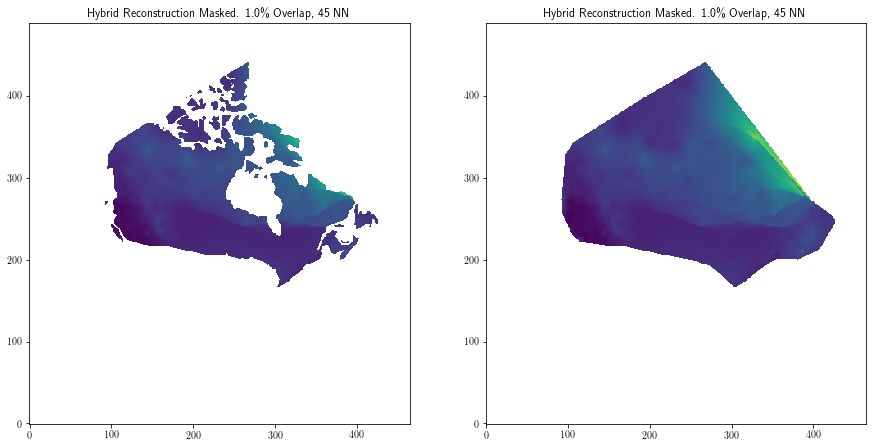

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))

ax[0].imshow(new_Z, origin='lower')
ax[0].set_title(f'Hybrid Reconstruction Masked. {frac_cov}\% Overlap, {nn} NN')

ax[1].imshow(np.nanmean(Zl, axis=0), origin='lower')
ax[1].set_title(f'Hybrid Reconstruction Masked. {frac_cov}\% Overlap, {nn} NN')

plt.savefig('reconstruction_with_station_only')

In [205]:
# Zl.shape
Zl = np.array(Zl)
# Zl_r = np.array(Zl_r)

# len(Zl_r)
# Zl[5].shape

In [206]:
canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)

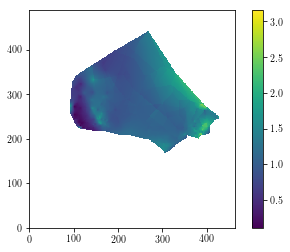

In [207]:
# gen_raster_mask_from_vector()
rec = np.nanmean(Zl, axis=0)
rec_nan = np.isnan(rec)
trouble_areas = np.logical_and(rec_nan, contained)
rec_ratio = np.nanmean(Zl, axis=0)#/ds_mean[dv].values
# rlon[rec_nan].size, rlon.shape
# # plt.imshow(np.logical_and(rec_nan, contained), origin='lower')
col = plt.imshow(rec_ratio, origin='lower')
plt.colorbar(col)
# plt.savefig('./email/ratio_clean')

In [208]:
# fig, ax = plt.subplots(1, 3, figsize=(10, 10))
# ax[0].imshow(contained, origin='lower')
# ax[0].set_title('Canada Reference on CanRCM4 Native Layout')
# ax[1].imshow(rec_ratio, origin='lower')
# ax[1].set_title('Kriged Field MW Example')
# ax[2].imshow(trouble_areas, origin='lower')
# ax[2].set_title('Areas in Canada missed by MW')
# plt.savefig('./email/canada_raster')

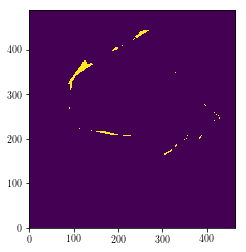

In [209]:
plt.imshow(trouble_areas, origin='lower')
plt.savefig('./email/not_covered')

In [210]:
ds_mean[dv].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

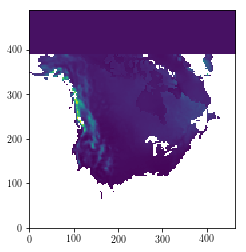

In [211]:
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import LinearNDInterpolator

f = NearestNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, rec_ratio[~rec_nan])
rec[trouble_areas] = f(np.stack([rlon[trouble_areas], rlat[trouble_areas]]).T)#*mean[trouble_areas]

rec_final = rec.copy()*ds_mean[dv].values
rec_final[~contained] = np.nan

nanrec = ~np.isnan(rec_final)
# f = LinearNDInterpolator(np.stack([rlon[nanrec], rlat[nanrec]]).T, rec_final[nanrec])

# rec_final[~nanrec] = f(np.stack([rlon[~nanrec], rlat[~nanrec]]).T) 
# # rec_final = rec_final*ds_mean[dv].values
# rec_final[~contained] = np.nan

# f = NearestNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, rec_final[~rec_nan])
# rec[trouble_areas] = f(np.stack([rlon[trouble_areas], rlat[trouble_areas]]).T)

# rec_final = rec.copy()#*ds_mean[dv].values
# rec_final[~contained] = np.nan

plt.imshow(ds_mean[dv].values, origin='lower')

In [231]:
rec_final = rec.copy()*ds_mean[dv].values
rec_final[~contained] = np.nan

nanrec = ~np.isnan(rec_final)
upper = np.nanmean(rec_final[ds.rlat.size:, :])
lower = np.nanmean(rec_final[ds.rlat.size-20:ds.rlat.size, :])
factor = lower/upper

rec_final[ds.rlat.size:, :] = rec_final[ds.rlat.size:, :]*factor 

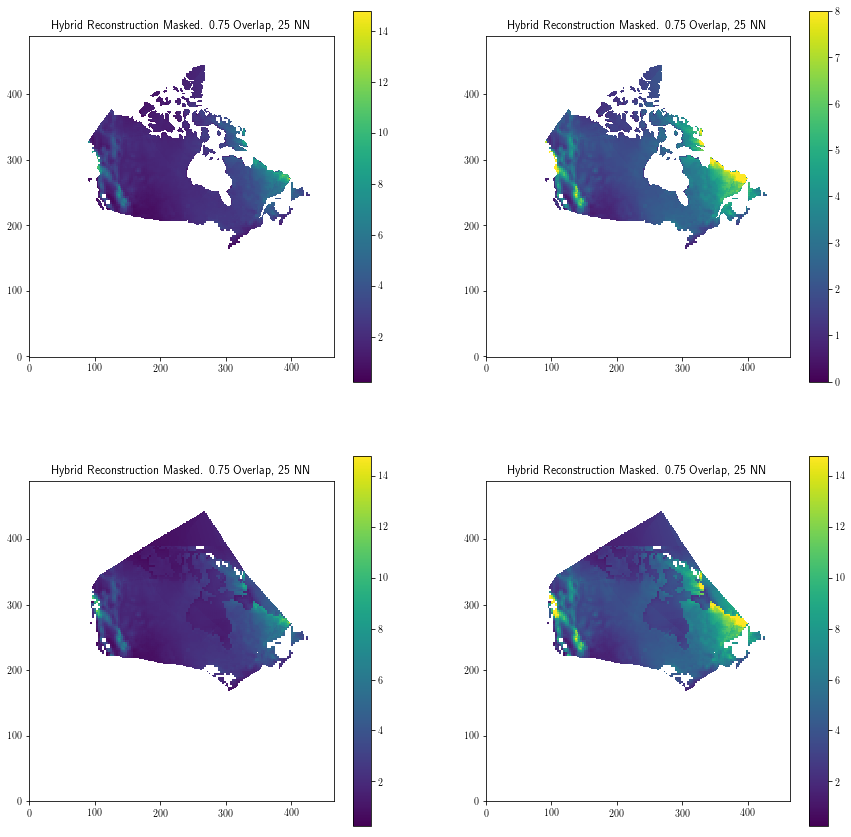

In [232]:
rec = np.nanmean(Zl, axis=0)
rec_nan = np.isnan(rec)
trouble_areas = np.logical_and(rec_nan, contained)
rec_ratio = np.nanmean(Zl, axis=0)

f = NearestNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, rec_ratio[~rec_nan])
rec[trouble_areas] = f(np.stack([rlon[trouble_areas], rlat[trouble_areas]]).T)#*mean[trouble_areas]

rec_final = rec.copy()*ds_mean[dv].values
rec_final[~contained] = np.nan

nanrec = ~np.isnan(rec_final)

rec_final = rec.copy()*ds_mean[dv].values
rec_final[~contained] = np.nan

nanrec = ~np.isnan(rec_final)
upper = np.nanmean(rec_final[ds.rlat.size:, :])
lower = np.nanmean(rec_final[ds.rlat.size-20:ds.rlat.size, :])
factor = lower/upper

rec_final[ds.rlat.size:, :] = rec_final[ds.rlat.size:, :]*factor 

fig, ax = plt.subplots(2, 2, figsize=(15, 15))
col1 = ax[0, 0].imshow(rec_final, origin='lower',)
ax[0, 0].set_title(f'Hybrid Reconstruction Masked. {frac_cov} Overlap, {nn} NN')
plt.colorbar(col1, ax=ax[0, 0])

ax[1, 0].imshow(np.nanmean(Zl, axis=0)*ds_mean[dv].values, origin='lower',)
ax[1, 0].set_title(f'Hybrid Reconstruction Masked. {frac_cov} Overlap, {nn} NN')
plt.colorbar(col1, ax=ax[1, 0])

col2 = ax[0, 1].imshow(rec_final, origin='lower', vmin=0, vmax=8)
ax[0, 1].set_title(f'Hybrid Reconstruction Masked. {frac_cov} Overlap, {nn} NN')
plt.colorbar(col2, ax=ax[0, 1])

ax[1, 1].imshow(np.nanmean(Zl, axis=0)*ds_mean[dv].values, origin='lower', vmin=0, vmax=8)
ax[1, 1].set_title(f'Hybrid Reconstruction Masked. {frac_cov} Overlap, {nn} NN')
plt.colorbar(col1, ax=ax[1, 1])

plt.savefig(f'scaling_comparisons_{frac_cov}_{nn}.png')

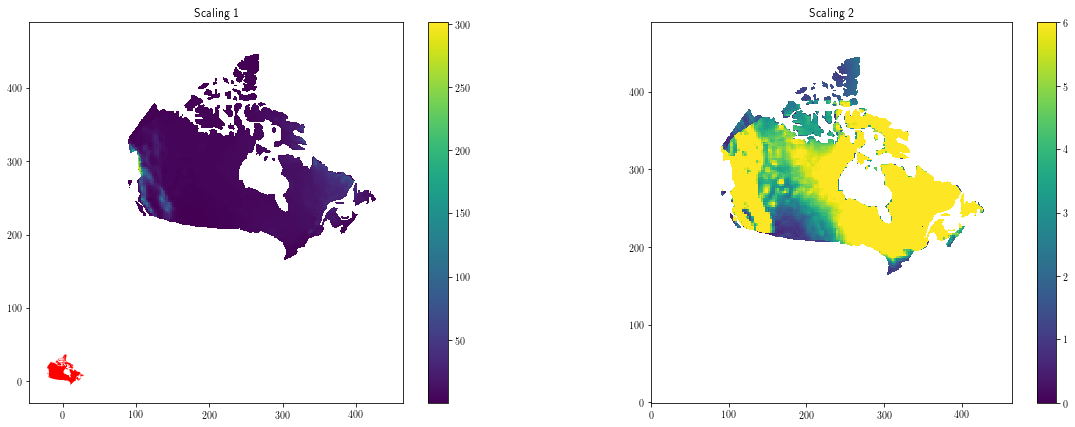

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
col = ax[0].imshow(rec_final, origin='lower',)
ax[0].set_title('Scaling 1')
canada.plot(ax=ax[0],zorder=0, color='r')
plt.colorbar(col, ax=ax[0])
col1 = ax[1].imshow(rec_final, origin='lower', vmin=0, vmax=6)
ax[1].set_title('Scaling 2')
plt.colorbar(col1, ax=ax[1])
plt.savefig('./email/scaling')

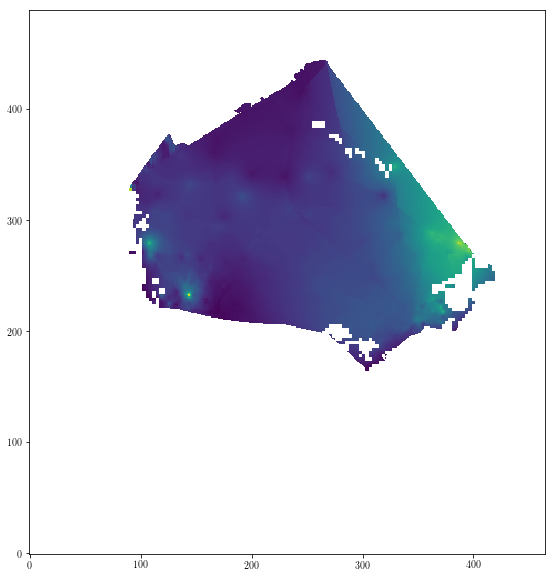

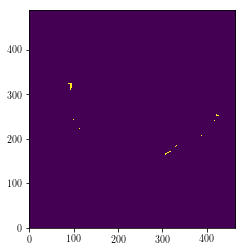

In [88]:
rec[trouble_areas] = ds_mean[dv].values[trouble_areas]
new_trouble_areas = np.logical_and(np.isnan(rec), contained)

f_lin = LinearNDInterpolator(np.stack([rlon[~rec_nan], rlat[~rec_nan]]).T, ds_mean[dv].values[~rec_nan])
rec_final[new_trouble_areas] = f_lin(np.stack([rlon[new_trouble_areas], rlat[new_trouble_areas]]).T)
plt.figure(figsize=(10, 10))
# plt.imshow(rec_final, origin='lower', vmin=1, vmax=5)
plt.imshow(rec_final, origin='lower')
plt.show()

plt.imshow(new_trouble_areas, origin='lower')

In [89]:
mmm = ~np.isnan(ds_mean[dv].values)
f_lin_full = LinearNDInterpolator(np.stack([rlon[mmm], rlat[mmm]]).T, rec_final[mmm])
final_ds = ds_mean.copy()
n = 10
dx = np.diff(final_ds.rlon.values).mean() / n
dy = np.diff(final_ds.rlat.values).mean() / n

# define new boundaries
x1 = final_ds.rlon.min() - dx
x2 = final_ds.rlon.max() + dx
y1 = final_ds.rlat.min() - dy
y2 = final_ds.rlat.max() + dy

# define new coordinate arrays
new_x = np.linspace(x1, x2, final_ds.rlon.size * n)
new_y = np.linspace(y1, y2, final_ds.rlat.size * n)

new_x, new_y = flatten_coords(new_x, new_y)

new_final_field = f_lin_full(np.stack([new_x, new_y]).T).reshape((final_ds.rlat.size * n, final_ds.rlon.size * n))

# regridded_ds = xr.Dataset(
#     {dv: (["rlat", "rlon"], new_ds), "lon": ds.lon, "lat": ds.lat},
#     coords={
#         "rlon": ("rlon", new_x),
#         "rlat": ("rlat", new_y),
#         "level": ("level", ds.level.values.astype(int)),
#     },
# )
# fig, ax = plt.subplots(figsize=(10, 10))
# x, y = flatten_coords(ds_mean.rlon, ds_mean.rlat)
newshape = np.repeat(np.repeat(contained, n, axis=0), n, axis=1).shape


xy = np.stack([new_x, new_y]).T
newcontained = []
for xcoord, ycoord in xy:
    newcontained.append(canada.contains(Point(xcoord, ycoord)))
    
newcontained = np.array(newcontained).reshape(newshape)


newmask = newcontained.copy() #np.repeat(np.repeat(newcontained, n, axis=0), n, axis=1)

new_final_field[~newmask] = np.nan
# col = plt.imshow(new_final_field, origin='lower', extent=extent, vmin=0, vmax=6)
# plt.colorbar(col)
# canada.plot(ax=ax, zorder=0)
# plt.savefig('final_reconstruction')

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
col = ax[0].imshow(new_final_field, origin='lower', extent=extent)
ax[0].set_title('Scaling 1')
canada.plot(ax=ax[0], zorder=0)
plt.colorbar(col, ax=ax[0])

col1 = ax[1].imshow(new_final_field, origin='lower', vmin=0, vmax=6, extent=extent)
ax[1].set_title('Scaling 2')
canada.plot(ax=ax[1], zorder=0)

plt.colorbar(col1, ax=ax[1])
plt.savefig('./email/scaling_final_res')

KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/home/nannau/tri/lib/python3.6/abc.py", line 184, in __instancecheck__
    if subclass in cls._abc_cache:
  File "/home/nannau/tri/lib/python3.6/_weakrefset.py", line 71, in __contains__
    try:
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
# GH Actions stuff with Nikola 
# Trying to get the docker-compose working in dv-explorer
# Running the infill in the background
# Producing more maps using moving window, moving onto more technical points that the method needs to address

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
col = ax[0].imshow(rec_final, origin='lower')
ax[0].set_title('Scaling 1')
plt.colorbar(col, ax=ax[0])
col1 = ax[1].imshow(rec_final, origin='lower', vmin=0, vmax=6)
ax[1].set_title('Scaling 2')
plt.colorbar(col1, ax=ax[1])
plt.savefig('./email/scaling')

In [ ]:
nugget = np.array(pykrige_variogram_parameters)[:, 2]
sill = np.array(pykrige_variogram_parameters)[:, 0]
range = np.array(pykrige_variogram_parameters)[:, 1]

In [ ]:
plt.figure(figsize=(10, 10))
# plt.plot(np.delete(nneighs, i_of_drop), np.array(loglike), label='lnProfileLike')
plt.plot(np.delete(nneighs, i_of_drop), np.array(reml), label='RMSE Spatial Process')
plt.plot(np.delete(nneighs, i_of_drop), np.array(nug_arr), label='Fitted Nugget Spatial Process')
# plt.plot(np.delete(nneighs, i_of_drop), np.array(dof), label='Fitted Nugget')
plt.legend()
plt.xlabel('N Stations')
plt.ylabel('RMSE')

plt.show()

plt.figure(figsize=(10, 10))
plt.plot(nneighs, nugget, label='nugget PyKrige')
plt.plot(nneighs, rmse, label='RMSE PyKrige')
# plt.plot(nneighs, sill, label='sill PyKrige')
# plt.plot(nneighs, range*3, label='range PyKrige')

# plt.plot(np.delete(nneighs, i_of_drop), np.array(dof), label='Fitted Nugget')

# plt.plot(np.delete(nneighs, i_of_drop), np.array(rmse), label='RMSE')
plt.legend()
plt.xlabel('N Stations')
plt.ylabel('RMSE')
# plt.title('Error Profiles Western Canada')
# plt.savefig('error_profiles_east')

In [ ]:
S_R_tup = sp.fit(np.stack([matched_df.rlon, matched_df.rlat]), matched_df[station_dv], S.shape[0], S.shape[1])

In [ ]:
S_R = S_R_tup[0]

In [ ]:
plt.scatter(np.sort(S_R.flatten()), np.sort(S.flatten()))

In [ ]:
z, x, y, cov = sp.fit(latlon, stats, xlim, ylim)
rlonlon, rlatlat = latlon
print(cov)
fit_params_names = ["N", "nugget", "range", "sill"]
fit_params = dict(zip(fit_params_names, cov[[0, 1, 2, 6]]))
# fit_params, cov

In [ ]:
from pykrige.ok import OrdinaryKriging
okie = OrdinaryKriging(rlonlon, rlatlat, stats, variogram_model='exponential', coordinates_type = "geographic")
# krigfield = okie.execute('points', rlon[region], rlat[region], exact_values=False)
# okie.display_variogram_model()
print(okie.variogram_model_parameters)
print(fit_params)

In [ ]:
r = np.linspace(0, 25, 100)

def variogram(params):
    return params['nugget']+params['sill']*(1-np.exp(-r/params['range']))

plt.plot(r, variogram(fit_params))

In [ ]:
# cov
nugget = d['summary'][1]
range_ = d['summary'][2]
sill = d['summary'][4]

nugget, range_, sill

In [ ]:
fit_params['nugget']+fit_params['sigma']*(1.0-np.exp(-r/))

In [ ]:
list(dict(zip(d['MLEJoint'].names, list(d['MLEJoint'])))['optimResults'])

In [ ]:
# range (distance), degs of freedom, p-values
# least squares departure from
# get the three parameters from kriging from spatialProcess for the variogram
# reconstruct the variogram
# put together mean squared error measure
# 

In [ ]:
se_dict
z_se_full = mean.copy()
z_se_full[lw:u, l:r] = z_se.T

np.nanmean(z_se_full[dfc.ilocy, dfc.ilocx]), np.nanmean(z_se_full)

In [ ]:
plt.imshow(z_se_full, origin='lower', vmin=0, vmax=1)
plt.show()
plt.imshow(z, origin='lower', vmin=0, vmax=10)
plt.show()

In [ ]:
# i_to_drop = []
# # Zl = []
# dfc = matched_df.copy()
# nn = 10
# nx = 10
# ny = 6
# boxdx, boxdy = (dfc.rlon.values.max()-dfc.rlon.values.min())/nx, (dfc.rlat.values.max()-dfc.rlat.values.min())/ny

# xstarts = np.linspace(dfc.rlon.values.min()+boxdx/2, dfc.rlon.values.max()-boxdx/2, nx)
# ystarts = np.linspace(dfc.rlat.values.min()+boxdy/2, dfc.rlat.values.max()-boxdy/2, ny)

# # y box
# for yc in ystarts:
#     #x box
#     for xc in xstarts:
#         ndf = dfc.copy()
#         condition = (ndf.rlon < xc+boxdx) & (ndf.rlon > xc-boxdx) & (ndf.rlat < yc+boxdy) & (ndf.rlat > yc-boxdy)
#         ndf = ndf[condition]
        
#         latlon = np.stack([ndf.rlon.values, ndf.rlat.values])
#         stats = ndf[station_dv].values
# #     stats = dfc['ratio'].values[ind[i]]
    
#         lw, u = find_nearest_index(ds_mean.rlat.values, yc-boxdy), find_nearest_index(ds_mean.rlat.values, yc+boxdy)
#         l, r = find_nearest_index(ds_mean.rlon.values, xc-boxdx), find_nearest_index(ds_mean.rlon.values, xc+boxdx)
#         ylim = u-lw
#         xlim = r-l
#         try:
#             z, x, y = sp.fit(latlon, stats, xlim, ylim)
#             final = mean.copy()
#             final[:, :] = np.nan
#             final[lw:u, l:r] = z.T#*mean[lw:u, l:r]
#         except:
#             i_to_drop.append(u)
#             pass
    
#         Zl.append(final)

In [ ]:
Zl = np.array(Zl)
# Zl_del = np.delete(Zl, i_to_drop, axis=0)
Zlmean = np.nanmean(Zl, axis=0)

In [ ]:
sums = np.sum(~np.isnan(Zl), axis=0)
plt.figure(figsize=(10, 10))
plt.imshow(sums, origin='lower', cmap=plt.cm.get_cmap("Greys", 100))
col = plt.colorbar()
plt.savefig("overlap_regions")

In [ ]:
Zlmean

In [ ]:
# plt.imshow(Zl[50, ...], origin='lower')
plt.figure(figsize=(10, 10))
# plt.imshow(Zlmean, origin='lower', cmap=plt.cm.get_cmap("viridis", 10), vmin=0, vmax=10)
plt.imshow(Zlmean, origin='lower')

In [ ]:
# del Zl_del
# del d_arrc_del
# np.delete(d_arr, i_to_drop, axis=0).shape, Zl.shape

In [ ]:
extent=[ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

In [ ]:
Zl = np.array(Zl)
Zlfill = Zl.copy()
Zlfill[~np.isnan(Zl)] = 0.0
fig, ax = plt.subplots(figsize=(10, 10))
for img in Zlfill[:, ...]:
    ax.imshow(img, origin='lower', extent = extent, alpha=0.3)

canada = gpd.read_file('../../climpyrical/tests/data/canada.geojson')
canada = rotate_shapefile(canada.geometry)
canada.plot(ax = ax, zorder = 0, color='grey')
plt.savefig("moving_window_overlap_random")

In [ ]:
from scipy.spatial.distance import pdist
from sklearn.neighbors import KNeighborsRegressor

a = np.array([rlon[final_mask], rlat[final_mask]]).T
a1 = np.array([matched_df.rlon.values, matched_df.rlat.values]).T
def pwhole_def(alpha):
#     s=time.time()
    c = mean.copy()
    d = np.amin(distance.cdist(a, a1, metric='euclidean'), axis=1)
#     d = pairwise_distances_argmin_min(a, a1[i], metric='euclidean')[1]
    c[final_mask] = np.exp(-alpha*d)
    c[~final_mask] = np.nan
#     print("Time:", time.time()-s)
    return c

plt.imshow(pwhole_def(1.))

In [ ]:
Z = np.nanmean(Zl, axis=0)
plt.figure(figsize=(10, 10))
plt.imshow(Z, origin='lower', vmin=0, vmax=6)

In [ ]:
# ds_test = ds_mean.drop('time')
# ds_test.assign('snw', Z)
# regridded_ds = xr.Dataset(
#     {dv: (["rlat", "rlon"], ds_mean), "lon": ds.lon, "lat": ds.lat},
#     coords={"rlon": ("rlon", new_x), "rlat": ("rlat", new_y)},
# )
ds_test = ds.copy()
A = ds[dv].values
A[0, ...] = Zlmean

ds_test = ds_test.assign({'snw': (["levels", "rlat", "rlon"], A)})
ds_test.to_netcdf('/home/nannau/06022020/dash-dv-explorer/assets/data/sl50_krig_reconstruction_stations.nc')

In [ ]:
ds_test[dv].shape[1:]

# Clustering

In [ ]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler

std = StandardScaler() 
N = 10
db = KMeans(n_clusters=N)
# db = DBSCAN(eps=0.2, min_samples=30, metric='haversine')

X = np.stack([matched_df.rlon, matched_df.rlat]).T
# X
# X = std.fit_transform(X.T)
db.fit(X)

db.labels_.shape, matched_df.shape[0]

matched_df = matched_df.assign(label = db.labels_)

sns.distplot(db.labels_, kde=False)

In [ ]:
ccenters = db.cluster_centers_
xcenter, ycenter = ccenters[:, 0], ccenters[:, 1]
xcenter, ycenter

In [ ]:
from scipy.spatial.distance import pdist
def pwhole_(alpha):
    rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)
    d_gridx = np.dstack((rlon, rlat))

    a = np.array([rlon[final_mask], rlat[final_mask]]).T
    a1 = np.array([xcenter, ycenter]).T

    d = cdist(a, a1)
    
#     d = db.kneighbors_graph(a, mode='distance').toarray()
#     denom = np.exp(-alpha*np.sum(np.sort(d, axis=1)[:, :1], axis=1))
#     num = np.exp(-alpha*np.sort(distance.cdist(a, a1), axis=1)[:, 0])

    p = np.exp(-alpha*d)#np.sort(d, axis=0))
    print(p.shape)
    pwhole = mean.copy()
    pwhole[final_mask] = pwhole
    pwhole[~final_mask] = np.nan
    return pwhole.reshape(mean.shape)


# plt.figure(figsize=(10, 10))
# plt.imshow(pwhole_(.5), origin='lower', vmin=0, vmax=1)
# np.nanmax(pwhole_(0.1))

In [ ]:
plt.figure(figsize=(8, 7))
print(np.unique(db.labels_).size)
sns.scatterplot(matched_df.rlon, matched_df.rlat, palette=sns.color_palette('muted', n_colors=N), hue=db.labels_)
sns.scatterplot(xcenter, ycenter, color = 'black', marker='x')
plt.title("K-Means Clustering on Station Data SL50")
plt.savefig('K-MeansCluster')

# Tool modifications:
* Extend ratios to station locations using closest model value - i.e. grid points behind stations using nearest 
* increase font sizes

# Tool notes:
* Understanding the audience
* Engineers tasked with building things
* Primary interest is a location:
* Point to a location select list of design values to get information from 
* Type in lat and lon and extract the design values
* Place a pin and get other design values or csv file/ascii file (secondary priority)
* New tab with selection of final design values


In [ ]:
S = Z.copy()
rmse = {
    'S_st': np.sqrt(mean_squared_error(S[dfc.ilocy, dfc.ilocx], dfc[station_dv])),
#     'R_b_st': np.sqrt(mean_squared_error(R_b[dfc.ilocy, dfc.ilocx], dfc[station_dv])),
    's_mod': np.sqrt(mean_squared_error(mean[dfc.ilocy, dfc.ilocx], dfc[station_dv])),
    'S_mod': np.sqrt(mean_squared_error(S[region], mean[region])),
#     'R_b_mod': np.sqrt(mean_squared_error(R_b[region], mean[region])),
}

bias = {
    'S_st': np.mean(S[dfc.ilocy, dfc.ilocx] - dfc[station_dv]),
    's_mod': np.mean(mean[dfc.ilocy, dfc.ilocx] - dfc[station_dv]),
    'S_mod': np.mean(mean[region] - S[region]),
}

rmse, bias

In [ ]:
tp = {
    'northern': {
        'x1': -20,
        'y1': 0,
        'x2': -20,
        'y2': 25.5,
        'x3': -20,
        'y3': 10,
    },
    'eastern': {
        'x1': 23,
        'y1': 0,
        'x2': 5,
        'y2': 12,
        'x3': 23,
        'y3': 0,
    },
    'western': {
        'x1': -5,
        'y1': 0,
        'x2': -20,
        'y2': 14,
        'x3': -5,
        'y3': 4,
    },
}
key = 'eastern'
text = tp[key]

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(45, 20))
zmin,zmax = -.5, np.amax(dfc[station_dv])+1.2
bmin, bmax = .6, 2.5
c = plt.cm.get_cmap("viridis_r", 10)
errorc = plt.cm.get_cmap("jet", 10)
extent=[dfc.rlon.min(), dfc.rlon.max(), dfc.rlat.min(), dfc.rlat.max()]
clevels = np.linspace(1, 15, 8) 

# Tile 0, 0
pos=(0, 0)
stations_only = ax[pos].scatter(dfc.rlon, dfc.rlat, c = dfc[station_dv], cmap=c,  vmin=zmin, vmax=zmax)
ax[pos].set_title('Stations SL50 (kPa) [$s$]', fontsize=15, weight='bold') 
ax[pos].text(text['x1'], text['y1'], f'count pre match: {df[region_cond_df].shape[0]}', fontsize=15)
ax[pos].text(text['x1'], text['y1']-1, f'count post match: {dfc.shape[0]}', fontsize=15)
plt.colorbar(stations_only, ax=ax[pos])

# Tile 0, 1
pos = (0, 1)
S_plot = ax[pos].imshow(regionalize(S), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[pos].set_title('Station Only Reconstruction SL50 (kPa) [$S$]', fontsize=15, weight='bold') 
S_plot_ct = ax[pos].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(S), 
    colors = ['black'], 
    levels = clevels)
ax[pos].clabel(S_plot_ct)
plt.colorbar(S_plot, ax=ax[pos])

# Tile 0, 3
pos = (1,0)
ens_mean = ax[pos].imshow(regionalize(mean), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[pos].set_title(r'Ensemble Mean SL50 (kPa) [$\mu$]', fontsize=15, weight='bold') 
mean_ct = ax[pos].contour(
    regionalize(rlon), 
    regionalize(rlat), 
    regionalize(mean), 
    colors = ['black'], 
    levels = clevels)
ax[pos].clabel(mean_ct)
plt.colorbar(ens_mean, ax=ax[pos])

# Tile 1, 0
# pos = (1, 2)
# stations_only_b = ax[pos].scatter(dfc.rlon, dfc.rlat, c = dfc.ratio, cmap=c, vmin=bmin, vmax=bmax)
# ax[pos].set_title('Station/Model Ratio [$b$]', fontsize=15, weight='bold') 
# plt.colorbar(stations_only_b, ax=ax[pos])

# Tile 1, 1
# pos = (2, 1)
# B_plot = ax[pos].imshow(regionalize(R_b), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
# ax[pos].set_title(r'Post Bias Reconstruction SL50 (kPa) [$R_b=B \times \mu$]', fontsize=15, weight='bold') 
# B_plot_ct = ax[pos].contour(
#     regionalize(rlon), 
#     regionalize(rlat), 
#     regionalize(R_b), 
#     colors = ['black'], 
#     levels = clevels)
# ax[pos].clabel(B_plot_ct)
# plt.colorbar(B_plot, ax=ax[pos])

# Tile 2, 0
# stations_only_post_bias = ax[2, 0].imshow(regionalize(B), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=bmin, vmax=bmax)
# ax[2, 0].set_title('Bias Reconstruction, [$B$]', fontsize=15, weight='bold') 
# ct_S_only_ps = ax[2, 0].contour(
#     regionalize(rlon), 
#     regionalize(rlat), 
#     regionalize(B), 
#     colors = ['black'], 
#     levels = np.linspace(0, 5, 10))
# ax[2, 0].clabel(ct_S_only_ps)
# plt.colorbar(stations_only_post_bias, ax=ax[2, 0])

# plt.savefig('tile_plot_sl50_east_krig.png')

In [ ]:
from rpy2.robjects.packages import importr
from rpy2 import robjects
import numpy as np
importr('fields', lib_loc='../r-library/fields')

In [ ]:
latlon = np.stack([dfc.rlon, dfc.rlat])
stats = dfc[station_dv].values
import climpyrical.spytialProcess as sp

In [ ]:
# r['surface'](tr)
import climpyrical.spytialProcess as sp
u, lw, l, rside
ylim = lw-u
xlim = rside-l
print(xlim, ylim)
z, x, y = sp.fit(latlon, stats, xlim, ylim)
z.shape

In [ ]:
lw-u

In [ ]:
u, lw, l, rside

In [ ]:
# z = np.array(list(dict(zip(tr.names, list(tr)))['z'])).reshape(ylim, xlim)
Z = mean.copy()
Z[~final_mask] = np.nan
Z[u:lw, l:rside] = z.T

In [ ]:
# region.shape[0], region.shape[1], Z[u:lw, l:r].size, z.size
Z[~final_mask] = np.nan

In [ ]:
plt.imshow(regionalize(Z), origin='lower')
x.size, y.size


In [ ]:
nanmaskz = ~np.isnan(Z[dfc.ilocy, dfc.ilocx])
krigz = Z[dfc.ilocy, dfc.ilocx][nanmaskz]

In [ ]:
plt.scatter(krigz, dfc[station_dv].values[nanmaskz])

In [ ]:
np.sqrt(mean_squared_error(krigz, dfc[station_dv].values[nanmaskz]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
zmin,zmax = -.5, np.amax(dfc[station_dv])+1.2
bmin, bmax = .6, 2.5
c = plt.cm.get_cmap("viridis_r", 10)
errorc = plt.cm.get_cmap("jet", 10)
extent=[dfc.rlon.min(), dfc.rlon.max(), dfc.rlat.min(), dfc.rlat.max()]
clevels = np.linspace(0, 12, 4) 
print(clevels)
clevels = [0, 2, 4, 6, 8, 12]

# Tile 0, 0
# pos=(0, 0)
pos = 0
stations_only = ax[pos].scatter(dfc.rlon, dfc.rlat, c = dfc[station_dv], cmap=c,  vmin=zmin, vmax=zmax)
ax[pos].set_title('Northern Stations SL50 (kPa) [$s$]', fontsize=15, weight='bold') 
# ax[pos].text(text['x1'], text['y1'], f'count pre match: {df[region_cond_df].shape[0]}', fontsize=15)
# ax[pos].text(text['x1'], text['y1']-1, f'count post match: {dfc.shape[0]}', fontsize=15)
plt.colorbar(stations_only, ax=ax[pos])

# Tile 0, 1
# pos = (0, 1)
pos = 1
S_plot = ax[pos].imshow(regionalize(Z), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
ax[pos].set_title('Northern Station Only Reconstruction Kriged SL50 (kPa) [$S$]', fontsize=15, weight='bold') 
S_plot_ct = ax[pos].contour(
    x, 
    y, 
    z, 
    colors = ['black'], 
    levels = clevels)
ax[pos].clabel(S_plot_ct)
plt.colorbar(S_plot, ax=ax[pos])

# # Tile 0, 3
# pos = (1,0)
# ens_mean = ax[pos].imshow(regionalize(mean), origin='lower', aspect='auto', extent=extent, cmap=c, vmin=zmin, vmax=zmax)
# ax[pos].set_title(r'Ensemble Mean SL50 (kPa) [$\mu$]', fontsize=15, weight='bold') 
# mean_ct = ax[pos].contour(
#     regionalize(rlon), 
#     regionalize(rlat), 
#     regionalize(mean), 
#     colors = ['black'], 
#     levels = clevels)
# ax[pos].clabel(mean_ct)
# plt.colorbar(ens_mean, ax=ax[pos])
plt.savefig('/home/nannau/Pictures/krig_example.png')

In [ ]:
N = np.arange(1, 40, 1)
combined_percentile = 0.99**N

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(N, 1-0.99**N, '--')
ax[0].set_title("Two Weeks Prior")
ax[0].set_xlabel("Number of People")
ax[0].set_ylabel("Effective Probability of Pre-Symptomatic Attendee")

ax[1].plot(N, 1-0.95**N, '--')
ax[1].set_title("One Week Prior")
ax[1].set_xlabel("Number of People")
ax[1].set_ylabel("Effective Probability of Pre-Symptomatic Attendee")

ax[2].plot(N, 1-0.5**N, '--')
ax[2].set_title("Five Days Prior")
ax[2].set_xlabel("Number of People")
ax[2].set_ylabel("Effective Probability of Pre-Symptomatic Attendee")

plt.savefig('/home/nannau/Desktop/Effective_rates')